In [411]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from numpy.linalg import norm


In [412]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [413]:
# Load the data
file_path = "SPY_section_1.csv"
df = pd.read_csv(file_path)

In [414]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [415]:
# Define LSTM model
class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [416]:
# Define the target variable
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)
df = df.dropna()

In [417]:
# Adding SMA and EMA to the feature
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean() # Short-term SMA
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean() # Medium-term SMA
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean() # Long-term SMA

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [418]:
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]

train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(X_scaled.shape)

Train: 1420, Val: 304, Test: 295
(2029, 11)


In [419]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


<span style="color: yellow; font-size: 40px;">Evaluating original LSTM</span>

In [420]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30


===== Evaluation Results =====
Test Loss: 36.7081
Test MAE: 4.6086
Average Error Percentage: 4.13%
Largest Error Percentage: 13.03%


<ipython-input-421-e7c8f65edd49>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=torch.device('cpu')))
/

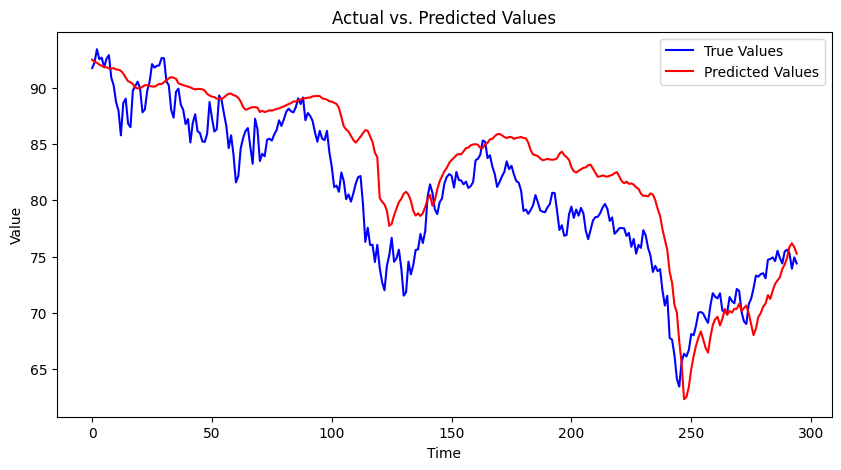

In [421]:
# Define paths
LSTM_model_path = "./lstm_codes/lstm_models/lstm_section_1.pth"  # Change this to your specific model file

# Load the trained model
LSTM_model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=torch.device('cpu')))
LSTM_model.eval()

# Define loss function
criterion = torch.nn.MSELoss()

# Evaluate on test data
test_loss = 0.0
test_mae = 0.0
all_true = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = LSTM_model(X_batch)
        loss = criterion(outputs, y_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))

        test_loss += loss.item() * X_batch.size(0)
        test_mae += mae.item() * X_batch.size(0)

        all_true.extend(y_batch.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Compute final metrics
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

# Compute error percentages
all_true = np.array(all_true).flatten()
all_preds = np.array(all_preds).flatten()
error = np.abs(all_true - all_preds) / (np.abs(all_true) + 1e-8)
avg_error = np.mean(error) * 100
largest_error = np.max(error) * 100

# Print results
print("\n===== Evaluation Results =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Average Error Percentage: {avg_error:.2f}%")
print(f"Largest Error Percentage: {largest_error:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(all_true, label='True Values', color='blue')
plt.plot(all_preds, label='Predicted Values', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


<span style="color: yellow; font-size: 40px;">Evaluating original autoencoder</span>

In [422]:
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

In [423]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [424]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [425]:
input_dim = X_train.shape[1]

# Hyperparameters
encoding_dim = 5
learning_rate = 0.0005
dropout_rate = 0.3
epochs = 750
batch_size = 16
patience = 40

In [426]:
autoencoder_model_path = "./autoencoder_codes/autoencoder_models/autoencoder_section_1.pth"
autoencoder_model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim, dropout_rate=dropout_rate).to(device)
autoencoder_model.load_state_dict(torch.load(autoencoder_model_path, map_location=torch.device('cpu')))

<ipython-input-426-163b13d6c5bf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load(autoencoder_model_path, map_location=torch.dev

<All keys matched successfully>

In [427]:
autoencoder_model.eval()
with torch.no_grad():
    reconstructed_test = autoencoder_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
mse = np.mean((X_test - reconstructed_test) ** 2)
mae = np.mean(np.abs(X_test - reconstructed_test))
ree = np.mean(np.linalg.norm(X_test - reconstructed_test, axis=1) / np.linalg.norm(X_test, axis=1))
euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
reconstruction_error_percentage = (
    np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
)
average_error = np.mean(reconstruction_error_percentage)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, REE: {ree:.4f}, Euclidean Distance: {euclidean_dist:.4f}, Average Error: {average_error:.4f}%')

MSE: 0.0016, MAE: 0.0273, REE: 0.0377, Euclidean Distance: 0.1188, Average Error: 2.8993%


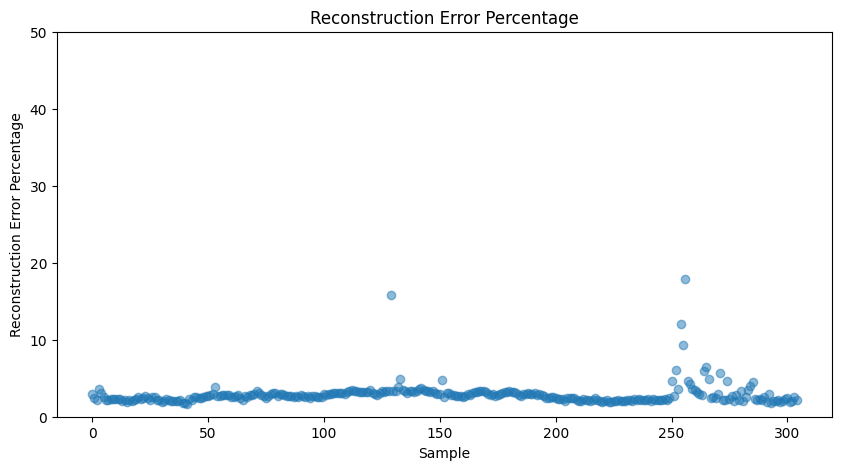

In [428]:
# Scatter plot of reconstruction error percentage
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, alpha=0.5)
plt.ylim(0, 50)
plt.xlabel('Sample')
plt.ylabel('Reconstruction Error Percentage')
plt.title('Reconstruction Error Percentage')
plt.show()


<span style="color: yellow; font-size: 40px;">Bias correction model - single input</span>

In [429]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size1, dropout_rate):
#         super(BiasPredictor, self).__init__()

#         hidden_size2 = hidden_size1 // 2
#         hidden_size3 = hidden_size2 // 2
#         hidden_size4 = hidden_size3 // 2  # New additional layer

#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.dropout1 = nn.Dropout(dropout_rate)

#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)

#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, hidden_size4)  # New additional layer
#         self.dropout4 = nn.Dropout(dropout_rate)

#         self.fc5 = nn.Linear(hidden_size4, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)

#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)

#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         x = F.relu(self.fc4(x))  # New layer
#         x = self.dropout4(x)

#         return self.fc5(x)

##################################################################

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size, dropout_rate):
#         super(BiasPredictor, self).__init__()

#         # Calculate progressively halved hidden sizes
#         hidden_size2 = hidden_size // 2
#         hidden_size3 = hidden_size2 // 2

#         # Define layers
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate)

#         self.fc2 = nn.Linear(hidden_size, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)

#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)

#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)

#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         return self.fc4(x)  # Output layer without activation

##################################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

class BiasPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(BiasPredictor, self).__init__()

        # Calculate progressively halved hidden sizes
        hidden_size2 = hidden_size // 2

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, 1)  # Final output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        return self.fc3(x)  # Output layer without activation




In [430]:
# Get LSTM predictions of entire dataset
with torch.no_grad():
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
    LSTM_preds = LSTM_model(X_tensor).cpu().numpy()

# Put LSTM predictions into a new DataFrame
new_df = pd.DataFrame(LSTM_preds, columns=["LSTM_Pred"])


In [431]:
# Drop the first sequence_length rows
temp_y = y
temp_y = temp_y[sequence_length:]

# add the target variable to the new DataFrame
new_df["Target"] = temp_y.values

In [432]:
# Get reconstruction error percentage for the entire dataset
autoencoder_model.eval()
with torch.no_grad():
    reconstructed = autoencoder_model(torch.tensor(X_scaled.values, dtype=torch.float32).to(device)).cpu().numpy()

# Compute the MAE
reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed), axis=1)

# Compute the reconstruction error percentage
# reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed) / (np.abs(X_scaled.values) + 1e-8), axis=1) * 100
# reconstruction_error = np.mean((X_scaled.values - reconstructed) / ((X_scaled.values) + 1e-8), axis=1) * 100

# Drop the first sequence_length rows
reconstruction_error_new = reconstruction_error[sequence_length:]

# Add the reconstruction error to the new DataFrame
new_df["Reconstruction_error_single"] = reconstruction_error_new

# Get reconstruction error arr of past 10 days
reconstruction_error_arr = []
for i in range(sequence_length, len(reconstruction_error)):
    reconstruction_error_arr.append(reconstruction_error[i - sequence_length:i])


# Add the reconstruction error array to the new DataFrame
new_df["Reconstruction_error_arr"] = reconstruction_error_arr



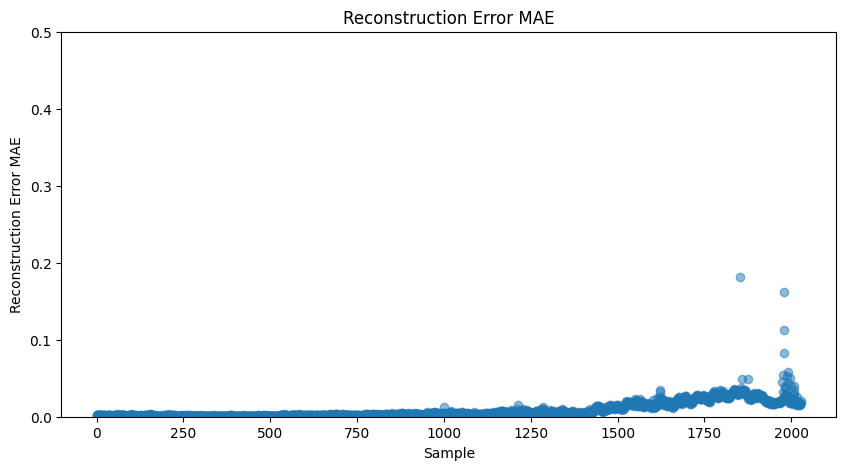

In [433]:
# plot reconstruction error scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, alpha=0.5)
plt.ylim(0, 0.5)
plt.xlabel('Sample')
# plt.ylabel('Reconstruction Error Percentage')
# plt.title('Reconstruction Error Percentage')
plt.ylabel('Reconstruction Error MAE')
plt.title('Reconstruction Error MAE')
plt.show()


In [434]:
reconstruction_error_arr[0]

array([0.00189878, 0.00180704, 0.00187237, 0.00172222, 0.00195921,
       0.00198496, 0.00210325, 0.00231761, 0.00201488, 0.00175625])

In [435]:
# Calculate the difference between the target and LSTM prediction
new_df["Bias"] = new_df["Target"] - new_df["LSTM_Pred"]

In [436]:
y = new_df["Bias"]
X = new_df["Reconstruction_error_single"]
# X = new_df["Reconstruction_error_arr"]

In [437]:
# Sequential split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train_raw = X[:train_size]
y_train_raw = y[:train_size]
X_val_raw = X[train_size:train_size + val_size]
y_val_raw = y[train_size:train_size + val_size]
X_test_raw = X[train_size + val_size:]
y_test_raw = y[train_size + val_size:]

# Scale using StandardScaler (fit only on train data)
# X_scaler = StandardScaler()
X_scaler = RobustScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw.values.reshape(-1, 1))
X_val_scaled = X_scaler.transform(X_val_raw.values.reshape(-1, 1))
X_test_scaled = X_scaler.transform(X_test_raw.values.reshape(-1, 1))

# y_scaler = StandardScaler()
y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val_raw.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test_raw.values.reshape(-1, 1))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Print sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1413, Val: 302, Test: 304


In [438]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Define model
# input_size = 1
# hidden_size1 = 64
# dropout_rate = 0.1
# learning_rate = 0.0001
# num_epochs = 500
# patience = 30

# bias_model = BiasPredictor(input_size=input_size, hidden_size1=hidden_size1, dropout_rate=dropout_rate).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

# # Train the model (don't need to save the model yet)
# best_val_loss = np.inf
# best_epoch = 0

# for epoch in range(num_epochs):
#     bias_model.train()
#     train_loss = 0.0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         outputs = bias_model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * X_batch.size(0)

#     train_loss /= len(train_loader.dataset)

#     bias_model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             outputs = bias_model(X_batch)
#             loss = criterion(outputs, y_batch)
#             val_loss += loss.item() * X_batch.size(0)

#     val_loss /= len(val_loader.dataset)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_epoch = epoch
#     elif epoch - best_epoch >= patience:
#         print(f"Stopping early at epoch {epoch}")
#         break

#     print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define hyperparameter search space
hidden_sizes = [32, 64, 128]
dropout_rates = [0.0, 0.1, 0.2]
learning_rates = [0.0001, 0.0005, 0.001]
batch_sizes = [8, 16, 32]

# Total number of hyperparameter combinations
total_combinations = len(hidden_sizes) * len(dropout_rates) * len(learning_rates) * len(batch_sizes)
combination_counter = 0

# Store results
results = []

# Iterate over all hyperparameter combinations
for hidden_size, dropout_rate, learning_rate, batch_size in itertools.product(hidden_sizes, dropout_rates, learning_rates, batch_sizes):
    combination_counter += 1
    print(f"\n Running {combination_counter}/{total_combinations}: H={hidden_size}, D={dropout_rate}, LR={learning_rate}, B={batch_size}")

    val_losses = []
    accuracies = []  # To track accuracies for each run
    for run in range(5):  # Run each combination 5 times
        print(f"   Run {run + 1}/5 ...", end=" ", flush=True)

        # Define DataLoaders with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define the model
        bias_model = BiasPredictor(input_size=1, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

        # Training setup
        best_val_loss = np.inf
        best_epoch = 0
        patience = 20
        num_epochs = 500

        # Training loop
        for epoch in range(num_epochs):
            bias_model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = bias_model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * X_batch.size(0)

            train_loss /= len(train_loader.dataset)

            # Validation
            bias_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = bias_model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item() * X_batch.size(0)

            val_loss /= len(val_loader.dataset)

            # Print progress every 50 epochs
            if epoch % 5 == 0:
                print(f"     Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
            elif epoch - best_epoch >= patience:
                print(f"    ⏹️ Early stopping at epoch {epoch}")
                break  # Stop training if no improvement

        val_losses.append(best_val_loss)  # Store best val loss for this run
        print(f" Run {run + 1} finished with best val loss: {best_val_loss:.4f}")

        # Evaluate accuracy after each run
        combined_X = torch.cat((X_train, X_val, X_test), dim=0)
        combined_y = torch.cat((y_train, y_val, y_test), dim=0)

        # Convert combined_X to tensor and scale if necessary
        X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)
        bias_model.eval()
        with torch.no_grad():
            y_pred = bias_model(X_scaled_tensor.to(device)).cpu().numpy()

        # Unscale outputs
        outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))

        # Calculate error percentages
        new_df["Bias_Pred"] = outputs_unscaled
        new_df["Corrected_LSTM_Pred"] = new_df["LSTM_Pred"] + new_df["Bias_Pred"]

        original_error_percent_test = np.mean(np.abs(new_df["Bias"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100
        corrected_error_percent_test = np.mean(np.abs(new_df["Target"].iloc[train_size + val_size:] - new_df["Corrected_LSTM_Pred"].iloc[train_size + val_size:]) / (np.abs(new_df["Target"].iloc[train_size + val_size:]) + 1e-8)) * 100

        print(f"Original Error Percentage (Test Dataset): {original_error_percent_test:.4f}%")
        print(f"Corrected Error Percentage (Test Dataset): {corrected_error_percent_test:.4f}%")

        # Store accuracy for this run
        accuracies.append(corrected_error_percent_test)

    # After all 5 trials, calculate the average accuracy
    avg_val_loss = np.mean(val_losses)
    avg_accuracy = np.mean(accuracies)  # Calculate the average error percentage over all runs

    results.append({
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "avg_val_loss": avg_val_loss,
        "avg_accuracy": avg_accuracy
    })

    print(f" Finished configuration H={hidden_size}, D={dropout_rate}, LR={learning_rate}, B={batch_size} → Avg Val Loss: {avg_val_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}%")

# Sort results by lowest validation loss
results.sort(key=lambda x: x["avg_val_loss"])

# Print top 5 configurations
print("\n Top 5 Hyperparameter Configurations:")
for i, res in enumerate(results[:5]):
    print(f" {i+1}. {res}")




 Running 1/81: H=32, D=0.0, LR=0.0001, B=8
   Run 1/5 ...      Epoch 0: Train Loss = 0.9474, Val Loss = 6.3899
     Epoch 5: Train Loss = 0.7377, Val Loss = 12.7133
     Epoch 10: Train Loss = 0.7185, Val Loss = 15.4448
     Epoch 15: Train Loss = 0.7170, Val Loss = 15.7660
     Epoch 20: Train Loss = 0.7169, Val Loss = 15.6111
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.3899
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2606%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7804, Val Loss = 9.7976
     Epoch 5: Train Loss = 0.7205, Val Loss = 14.4448
     Epoch 10: Train Loss = 0.7173, Val Loss = 15.2802
     Epoch 15: Train Loss = 0.7164, Val Loss = 14.9517
     Epoch 20: Train Loss = 0.7162, Val Loss = 14.9322
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.7976
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0715%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.9082, Val Loss = 6.4048
     Epoch 5: Train Loss = 0.7383, Val Loss = 12.7513
     Epoch 10: Train Loss = 0.7202, Val Loss = 15.3296
     Epoch 15: Train Loss = 0.7177, Val Loss = 15.5505
     Epoch 20: Train Loss = 0.7169, Val Loss = 15.5170
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.4048
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2126%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8030, Val Loss = 7.0708
     Epoch 5: Train Loss = 0.7304, Val Loss = 10.7414
     Epoch 10: Train Loss = 0.7189, Val Loss = 11.8887
     Epoch 15: Train Loss = 0.7168, Val Loss = 11.7897
     Epoch 20: Train Loss = 0.7170, Val Loss = 11.9942
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.0708
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3375%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8042, Val Loss = 5.6105
     Epoch 5: Train Loss = 0.7539, Val Loss = 6.5498
     Epoch 10: Train Loss = 0.7309, Val Loss = 7.9045
     Epoch 15: Train Loss = 0.7207, Val Loss = 9.2558
     Epoch 20: Train Loss = 0.7174, Val Loss = 10.2610
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 5.6105
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.1413%
 Finished configuration H=32, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 7.0547, Avg Accuracy: 3.8047%

 Running 2/81: H=32, D=0.0, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.8005, Val Loss = 6.5120


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7428, Val Loss = 8.9997
     Epoch 10: Train Loss = 0.7238, Val Loss = 11.0223
     Epoch 15: Train Loss = 0.7193, Val Loss = 12.0748
     Epoch 20: Train Loss = 0.7180, Val Loss = 12.3747
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.5120
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4109%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8381, Val Loss = 5.6617


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7551, Val Loss = 7.3739
     Epoch 10: Train Loss = 0.7266, Val Loss = 9.1561
     Epoch 15: Train Loss = 0.7189, Val Loss = 10.4486
     Epoch 20: Train Loss = 0.7171, Val Loss = 11.2569
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.6617
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2253%
   Run 3/5 ...      Epoch 0: Train Loss = 0.9774, Val Loss = 5.5641


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7663, Val Loss = 9.2404
     Epoch 10: Train Loss = 0.7279, Val Loss = 12.4941
     Epoch 15: Train Loss = 0.7196, Val Loss = 14.2909
     Epoch 20: Train Loss = 0.7175, Val Loss = 14.7204
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 5.5641
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0108%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8657, Val Loss = 5.3789


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7679, Val Loss = 7.7831
     Epoch 10: Train Loss = 0.7290, Val Loss = 10.6485
     Epoch 15: Train Loss = 0.7208, Val Loss = 12.1238
     Epoch 20: Train Loss = 0.7182, Val Loss = 12.3953
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.3789
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4590%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8389, Val Loss = 5.5296


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7390, Val Loss = 8.2589
     Epoch 10: Train Loss = 0.7199, Val Loss = 10.4628
     Epoch 15: Train Loss = 0.7178, Val Loss = 11.3467
     Epoch 20: Train Loss = 0.7170, Val Loss = 11.7247
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 5.5296
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2795%
 Finished configuration H=32, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 5.7293, Avg Accuracy: 3.4771%

 Running 3/81: H=32, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 1.0618, Val Loss = 5.3140


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.8354, Val Loss = 6.6167
     Epoch 10: Train Loss = 0.7429, Val Loss = 9.9279
     Epoch 15: Train Loss = 0.7218, Val Loss = 12.7270
     Epoch 20: Train Loss = 0.7180, Val Loss = 13.6445
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.3140
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7132%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8465, Val Loss = 6.2366


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7583, Val Loss = 8.7520
     Epoch 10: Train Loss = 0.7291, Val Loss = 10.9253
     Epoch 15: Train Loss = 0.7203, Val Loss = 12.3344
     Epoch 20: Train Loss = 0.7174, Val Loss = 12.9105
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.2366
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5546%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8306, Val Loss = 6.1167


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7514, Val Loss = 7.3425
     Epoch 10: Train Loss = 0.7273, Val Loss = 8.7878
     Epoch 15: Train Loss = 0.7191, Val Loss = 10.0652
     Epoch 20: Train Loss = 0.7169, Val Loss = 10.8027
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.1167
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2067%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8183, Val Loss = 7.0959


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7625, Val Loss = 8.1282
     Epoch 10: Train Loss = 0.7364, Val Loss = 9.4098
     Epoch 15: Train Loss = 0.7241, Val Loss = 10.4207
     Epoch 20: Train Loss = 0.7192, Val Loss = 11.2166
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.0959
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2274%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7668, Val Loss = 9.3242


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7365, Val Loss = 11.0874
     Epoch 10: Train Loss = 0.7245, Val Loss = 12.3476
     Epoch 15: Train Loss = 0.7204, Val Loss = 12.9284
     Epoch 20: Train Loss = 0.7187, Val Loss = 13.5314
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.3242
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6936%
 Finished configuration H=32, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 6.8175, Avg Accuracy: 3.4791%

 Running 4/81: H=32, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7593, Val Loss = 13.3517
     Epoch 5: Train Loss = 0.7183, Val Loss = 14.5851
     Epoch 10: Train Loss = 0.7179, Val Loss = 14.6066
     Epoch 15: Train Loss = 0.7165, Val Loss = 14.5224
     Epoch 20: Train Loss = 0.7163, Val Loss = 14.9695
     Epoch 25: Train Loss = 0.7149, Val Loss = 15.0105
     Epoch 30: Train Loss = 0.7147, Val Loss = 16.3942
     Epoch 35: Train Loss = 0.7140, Val Loss = 16.5540
    ⏹️ Early stopping at epoch 36
 Run 1 finished with best val loss: 13.2856
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7371%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7618, Val Loss = 11.6834
     Epoch 5: Train Loss = 0.7176, Val Loss = 12.1871
     Epoch 10: Train Loss = 0.7177, Val Loss = 13.1407
     Epoch 15: Train Loss = 0.7163, Val Loss = 12.3580
     Epoch 20: Train Loss = 0.7150, Val Loss = 13.8810
     Epoch 25: Train Loss = 0.7151, Val Loss = 12.5183
     Epoch 30: Train Loss = 0.7160, Val Loss = 14.0119
    ⏹️ Early stopping at epoch 34
 Run 2 finished with best val loss: 10.7198
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9285%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7564, Val Loss = 11.2682
     Epoch 5: Train Loss = 0.7192, Val Loss = 12.8728
     Epoch 10: Train Loss = 0.7164, Val Loss = 13.5911
     Epoch 15: Train Loss = 0.7181, Val Loss = 13.4701
     Epoch 20: Train Loss = 0.7168, Val Loss = 12.9640
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.2682
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5970%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7834, Val Loss = 9.1369
     Epoch 5: Train Loss = 0.7165, Val Loss = 12.7853
     Epoch 10: Train Loss = 0.7169, Val Loss = 12.4249
     Epoch 15: Train Loss = 0.7164, Val Loss = 12.4733
     Epoch 20: Train Loss = 0.7157, Val Loss = 13.6435
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.1369
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7038%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7850, Val Loss = 14.5522
     Epoch 5: Train Loss = 0.7187, Val Loss = 16.2558
     Epoch 10: Train Loss = 0.7186, Val Loss = 15.4888
     Epoch 15: Train Loss = 0.7191, Val Loss = 15.0570
     Epoch 20: Train Loss = 0.7177, Val Loss = 15.2024
     Epoch 25: Train Loss = 0.7175, Val Loss = 16.2069
    ⏹️ Early stopping at epoch 28
 Run 5 finished with best val loss: 13.9994
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2936%
 Finished configuration H=32, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 11.6820, Avg Accuracy: 4.0520%

 Running 5/81: H=32, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.8671, Val Loss = 7.7386


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7178, Val Loss = 14.3465
     Epoch 10: Train Loss = 0.7163, Val Loss = 14.2364
     Epoch 15: Train Loss = 0.7164, Val Loss = 14.9041
     Epoch 20: Train Loss = 0.7156, Val Loss = 15.2020
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.7386
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1153%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8056, Val Loss = 9.5514


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7180, Val Loss = 12.4497
     Epoch 10: Train Loss = 0.7185, Val Loss = 11.9807
     Epoch 15: Train Loss = 0.7163, Val Loss = 11.9049
     Epoch 20: Train Loss = 0.7163, Val Loss = 12.0967
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.5514
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3650%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8364, Val Loss = 9.9516


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7180, Val Loss = 14.4065
     Epoch 10: Train Loss = 0.7177, Val Loss = 14.7940
     Epoch 15: Train Loss = 0.7166, Val Loss = 14.9255
     Epoch 20: Train Loss = 0.7152, Val Loss = 15.0953
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.9516
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1511%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7572, Val Loss = 7.8684


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7171, Val Loss = 11.2302
     Epoch 10: Train Loss = 0.7157, Val Loss = 12.2947
     Epoch 15: Train Loss = 0.7147, Val Loss = 13.7716
     Epoch 20: Train Loss = 0.7143, Val Loss = 13.8239
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.8684
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7913%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7806, Val Loss = 10.5192


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7185, Val Loss = 14.8638
     Epoch 10: Train Loss = 0.7181, Val Loss = 14.9916
     Epoch 15: Train Loss = 0.7153, Val Loss = 14.0614
     Epoch 20: Train Loss = 0.7152, Val Loss = 14.2883
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.5192
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9844%
 Finished configuration H=32, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 9.1258, Avg Accuracy: 3.8814%

 Running 6/81: H=32, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7670, Val Loss = 12.7496


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7265, Val Loss = 15.6306
     Epoch 10: Train Loss = 0.7203, Val Loss = 13.1219
     Epoch 15: Train Loss = 0.7176, Val Loss = 13.1674
     Epoch 20: Train Loss = 0.7158, Val Loss = 12.9990
     Epoch 25: Train Loss = 0.7162, Val Loss = 11.5006
     Epoch 30: Train Loss = 0.7178, Val Loss = 12.1232
     Epoch 35: Train Loss = 0.7160, Val Loss = 12.6858
     Epoch 40: Train Loss = 0.7153, Val Loss = 12.7196
     Epoch 45: Train Loss = 0.7155, Val Loss = 12.6558
    ⏹️ Early stopping at epoch 45
 Run 1 finished with best val loss: 11.5006
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5068%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8574, Val Loss = 7.8487


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7174, Val Loss = 14.7526
     Epoch 10: Train Loss = 0.7171, Val Loss = 13.7661
     Epoch 15: Train Loss = 0.7158, Val Loss = 13.8581
     Epoch 20: Train Loss = 0.7157, Val Loss = 13.5000
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.8487
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6953%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8074, Val Loss = 6.7174


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7171, Val Loss = 10.5906
     Epoch 10: Train Loss = 0.7166, Val Loss = 11.1098
     Epoch 15: Train Loss = 0.7168, Val Loss = 11.0258
     Epoch 20: Train Loss = 0.7185, Val Loss = 11.3787
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.7174
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2582%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7917, Val Loss = 12.8384


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7214, Val Loss = 16.9469
     Epoch 10: Train Loss = 0.7182, Val Loss = 15.3259
     Epoch 15: Train Loss = 0.7167, Val Loss = 14.3790
     Epoch 20: Train Loss = 0.7155, Val Loss = 14.0549
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.8384
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8685%
   Run 5/5 ...      Epoch 0: Train Loss = 0.9397, Val Loss = 6.3268


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7188, Val Loss = 15.2163
     Epoch 10: Train Loss = 0.7175, Val Loss = 14.0673
     Epoch 15: Train Loss = 0.7164, Val Loss = 13.9504
     Epoch 20: Train Loss = 0.7158, Val Loss = 14.2136
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.3268
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8553%
 Finished configuration H=32, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 9.0464, Avg Accuracy: 3.6368%

 Running 7/81: H=32, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7793, Val Loss = 11.5457
     Epoch 5: Train Loss = 0.7207, Val Loss = 13.8252
     Epoch 10: Train Loss = 0.7183, Val Loss = 14.4024
     Epoch 15: Train Loss = 0.7179, Val Loss = 16.1656
     Epoch 20: Train Loss = 0.7190, Val Loss = 19.5474
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.5457
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.3045%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7438, Val Loss = 15.8077
     Epoch 5: Train Loss = 0.7222, Val Loss = 14.3236
     Epoch 10: Train Loss = 0.7184, Val Loss = 14.0929
     Epoch 15: Train Loss = 0.7202, Val Loss = 13.8376
     Epoch 20: Train Loss = 0.7209, Val Loss = 12.8978
     Epoch 25: Train Loss = 0.7177, Val Loss = 12.6696
     Epoch 30: Train Loss = 0.7168, Val Loss = 14.5876
    ⏹️ Early stopping at epoch 31
 Run 2 finished with best val loss: 11.7796
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7060%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7406, Val Loss = 12.4310
     Epoch 5: Train Loss = 0.7198, Val Loss = 11.8016
     Epoch 10: Train Loss = 0.7177, Val Loss = 13.8736
     Epoch 15: Train Loss = 0.7172, Val Loss = 12.7548
     Epoch 20: Train Loss = 0.7164, Val Loss = 12.9645
    ⏹️ Early stopping at epoch 24
 Run 3 finished with best val loss: 11.5533
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7770%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7592, Val Loss = 9.1733
     Epoch 5: Train Loss = 0.7184, Val Loss = 11.3267
     Epoch 10: Train Loss = 0.7176, Val Loss = 10.9120
     Epoch 15: Train Loss = 0.7168, Val Loss = 13.2880
     Epoch 20: Train Loss = 0.7168, Val Loss = 12.8066
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.1733
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4687%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7797, Val Loss = 14.1746
     Epoch 5: Train Loss = 0.7195, Val Loss = 11.9285
     Epoch 10: Train Loss = 0.7186, Val Loss = 12.9627
     Epoch 15: Train Loss = 0.7188, Val Loss = 13.4817
     Epoch 20: Train Loss = 0.7172, Val Loss = 13.4717
     Epoch 25: Train Loss = 0.7182, Val Loss = 13.3974
    ⏹️ Early stopping at epoch 29
 Run 5 finished with best val loss: 11.5892
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8611%
 Finished configuration H=32, D=0.0, LR=0.001, B=8 → Avg Val Loss: 11.1282, Avg Accuracy: 4.0235%

 Running 8/81: H=32, D=0.0, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7653, Val Loss = 15.3241


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7181, Val Loss = 12.8819
     Epoch 10: Train Loss = 0.7191, Val Loss = 13.1812
     Epoch 15: Train Loss = 0.7164, Val Loss = 14.0044
     Epoch 20: Train Loss = 0.7161, Val Loss = 14.4578
     Epoch 25: Train Loss = 0.7145, Val Loss = 15.1570
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 12.8819
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1893%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7613, Val Loss = 11.6134


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7188, Val Loss = 12.5067
     Epoch 10: Train Loss = 0.7165, Val Loss = 12.5303
     Epoch 15: Train Loss = 0.7158, Val Loss = 13.3130
     Epoch 20: Train Loss = 0.7157, Val Loss = 13.3108
     Epoch 25: Train Loss = 0.7166, Val Loss = 13.6139
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 11.0633
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7530%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7926, Val Loss = 14.0304


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7162, Val Loss = 16.1830
     Epoch 10: Train Loss = 0.7175, Val Loss = 15.3988
     Epoch 15: Train Loss = 0.7171, Val Loss = 14.9452
     Epoch 20: Train Loss = 0.7158, Val Loss = 15.9906
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 13.7516
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0182%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7397, Val Loss = 12.2913
     Epoch 5: Train Loss = 0.7206, Val Loss = 12.9005
     Epoch 10: Train Loss = 0.7169, Val Loss = 14.9312
     Epoch 15: Train Loss = 0.7170, Val Loss = 14.5825
     Epoch 20: Train Loss = 0.7188, Val Loss = 15.1343
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 11.3989
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.5537%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8027, Val Loss = 11.8752


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7189, Val Loss = 12.9412
     Epoch 10: Train Loss = 0.7180, Val Loss = 13.8938
     Epoch 15: Train Loss = 0.7164, Val Loss = 13.7617
     Epoch 20: Train Loss = 0.7168, Val Loss = 14.5117
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.8752
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0455%
 Finished configuration H=32, D=0.0, LR=0.001, B=16 → Avg Val Loss: 12.1942, Avg Accuracy: 4.3119%

 Running 9/81: H=32, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8118, Val Loss = 11.2976


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7186, Val Loss = 11.7064
     Epoch 10: Train Loss = 0.7178, Val Loss = 14.8614
     Epoch 15: Train Loss = 0.7154, Val Loss = 13.6302
     Epoch 20: Train Loss = 0.7201, Val Loss = 13.5603
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.2976
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7115%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7722, Val Loss = 11.9077


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7183, Val Loss = 12.3079
     Epoch 10: Train Loss = 0.7169, Val Loss = 12.4859
     Epoch 15: Train Loss = 0.7163, Val Loss = 13.0199
     Epoch 20: Train Loss = 0.7165, Val Loss = 13.3139
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.9077
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6155%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7827, Val Loss = 13.2240


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7198, Val Loss = 12.9727
     Epoch 10: Train Loss = 0.7151, Val Loss = 13.7815
     Epoch 15: Train Loss = 0.7177, Val Loss = 14.2799
     Epoch 20: Train Loss = 0.7155, Val Loss = 14.7365
     Epoch 25: Train Loss = 0.7153, Val Loss = 15.6315
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 12.9727
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2990%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7504, Val Loss = 10.5354


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7175, Val Loss = 12.0501
     Epoch 10: Train Loss = 0.7162, Val Loss = 12.6697
     Epoch 15: Train Loss = 0.7163, Val Loss = 13.3017
     Epoch 20: Train Loss = 0.7149, Val Loss = 13.7769
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.5354
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8115%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7781, Val Loss = 8.5091


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7191, Val Loss = 11.6867
     Epoch 10: Train Loss = 0.7173, Val Loss = 12.1891
     Epoch 15: Train Loss = 0.7183, Val Loss = 11.5464
     Epoch 20: Train Loss = 0.7167, Val Loss = 12.8777
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.5091
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5280%
 Finished configuration H=32, D=0.0, LR=0.001, B=32 → Avg Val Loss: 11.0445, Avg Accuracy: 3.7931%

 Running 10/81: H=32, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8126, Val Loss = 6.9067
     Epoch 5: Train Loss = 0.7370, Val Loss = 12.3965
     Epoch 10: Train Loss = 0.7317, Val Loss = 13.9616
     Epoch 15: Train Loss = 0.7207, Val Loss = 13.7656
     Epoch 20: Train Loss = 0.7145, Val Loss = 14.0158
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.9067
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8713%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.9434, Val Loss = 6.7166
     Epoch 5: Train Loss = 0.7323, Val Loss = 12.9642
     Epoch 10: Train Loss = 0.7458, Val Loss = 14.4247
     Epoch 15: Train Loss = 0.7268, Val Loss = 14.6741
     Epoch 20: Train Loss = 0.7255, Val Loss = 14.5357
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.7166
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9485%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8709, Val Loss = 7.5498
     Epoch 5: Train Loss = 0.7313, Val Loss = 13.6732
     Epoch 10: Train Loss = 0.7255, Val Loss = 14.5334
     Epoch 15: Train Loss = 0.7430, Val Loss = 14.1389
     Epoch 20: Train Loss = 0.7322, Val Loss = 14.5069
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.5498
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0029%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7958, Val Loss = 8.1169
     Epoch 5: Train Loss = 0.7401, Val Loss = 12.9852
     Epoch 10: Train Loss = 0.7301, Val Loss = 14.1290
     Epoch 15: Train Loss = 0.7379, Val Loss = 14.0462
     Epoch 20: Train Loss = 0.7281, Val Loss = 14.1499
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.1169
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8998%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8345, Val Loss = 6.0148
     Epoch 5: Train Loss = 0.7476, Val Loss = 10.5174
     Epoch 10: Train Loss = 0.7319, Val Loss = 13.4749
     Epoch 15: Train Loss = 0.7210, Val Loss = 13.9753
     Epoch 20: Train Loss = 0.7263, Val Loss = 14.0623
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.0148
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8335%
 Finished configuration H=32, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 7.0610, Avg Accuracy: 3.9112%

 Running 11/81: H=32, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 1.0033, Val Loss = 5.5025


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7584, Val Loss = 12.4275
     Epoch 10: Train Loss = 0.7347, Val Loss = 15.4575
     Epoch 15: Train Loss = 0.7314, Val Loss = 15.9898
     Epoch 20: Train Loss = 0.7363, Val Loss = 15.7298
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.5025
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2372%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8125, Val Loss = 6.0619


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7544, Val Loss = 7.6940
     Epoch 10: Train Loss = 0.7352, Val Loss = 9.2253
     Epoch 15: Train Loss = 0.7237, Val Loss = 10.0205
     Epoch 20: Train Loss = 0.7188, Val Loss = 10.4746
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.0619
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.1483%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8023, Val Loss = 6.6597


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7295, Val Loss = 8.8083
     Epoch 10: Train Loss = 0.7314, Val Loss = 10.3418
     Epoch 15: Train Loss = 0.7231, Val Loss = 11.0581
     Epoch 20: Train Loss = 0.7270, Val Loss = 11.3823
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.6597
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2766%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8312, Val Loss = 7.1743


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7517, Val Loss = 10.7970
     Epoch 10: Train Loss = 0.7350, Val Loss = 12.8247
     Epoch 15: Train Loss = 0.7406, Val Loss = 13.2652
     Epoch 20: Train Loss = 0.7324, Val Loss = 13.2451
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.1743
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5762%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7885, Val Loss = 8.2978
     Epoch 5: Train Loss = 0.7376, Val Loss = 9.6235
     Epoch 10: Train Loss = 0.7194, Val Loss = 10.6070
     Epoch 15: Train Loss = 0.7253, Val Loss = 10.8296
     Epoch 20: Train Loss = 0.7227, Val Loss = 10.9028
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.2978
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.1881%
 Finished configuration H=32, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 6.7392, Avg Accuracy: 3.4853%

 Running 12/81: H=32, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8198, Val Loss = 8.3499


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7708, Val Loss = 11.7487
     Epoch 10: Train Loss = 0.7486, Val Loss = 14.7042
     Epoch 15: Train Loss = 0.7387, Val Loss = 15.8597
     Epoch 20: Train Loss = 0.7463, Val Loss = 16.8596
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 8.3499
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6836%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8451, Val Loss = 6.2953


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7827, Val Loss = 8.2281
     Epoch 10: Train Loss = 0.7481, Val Loss = 10.4840
     Epoch 15: Train Loss = 0.7323, Val Loss = 11.7483
     Epoch 20: Train Loss = 0.7257, Val Loss = 12.4382
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.2953
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4572%
   Run 3/5 ...      Epoch 0: Train Loss = 1.0578, Val Loss = 5.7216


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.8394, Val Loss = 8.2246
     Epoch 10: Train Loss = 0.7648, Val Loss = 11.3266
     Epoch 15: Train Loss = 0.7384, Val Loss = 13.9480
     Epoch 20: Train Loss = 0.7184, Val Loss = 15.8777
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 5.7216
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3300%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7822, Val Loss = 7.8250


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7516, Val Loss = 9.1452
     Epoch 10: Train Loss = 0.7382, Val Loss = 10.2572
     Epoch 15: Train Loss = 0.7266, Val Loss = 11.0287
     Epoch 20: Train Loss = 0.7312, Val Loss = 11.3529
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.8250
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2628%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8188, Val Loss = 7.3182


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7633, Val Loss = 8.5738
     Epoch 10: Train Loss = 0.7430, Val Loss = 9.6733
     Epoch 15: Train Loss = 0.7348, Val Loss = 10.6658
     Epoch 20: Train Loss = 0.7233, Val Loss = 11.4127
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 7.3182
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3318%
 Finished configuration H=32, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 7.1020, Avg Accuracy: 3.8131%

 Running 13/81: H=32, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8255, Val Loss = 12.4004
     Epoch 5: Train Loss = 0.7266, Val Loss = 15.1155
     Epoch 10: Train Loss = 0.7309, Val Loss = 14.3307
     Epoch 15: Train Loss = 0.7283, Val Loss = 14.4917
     Epoch 20: Train Loss = 0.7117, Val Loss = 15.6368
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.4004
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2357%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8415, Val Loss = 11.9798
     Epoch 5: Train Loss = 0.7210, Val Loss = 16.7567
     Epoch 10: Train Loss = 0.7213, Val Loss = 14.7747
     Epoch 15: Train Loss = 0.7218, Val Loss = 13.8511
     Epoch 20: Train Loss = 0.7154, Val Loss = 15.6253
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.9798
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3702%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7798, Val Loss = 8.8342
     Epoch 5: Train Loss = 0.7352, Val Loss = 10.6231
     Epoch 10: Train Loss = 0.7333, Val Loss = 10.7736
     Epoch 15: Train Loss = 0.7227, Val Loss = 11.3840
     Epoch 20: Train Loss = 0.7178, Val Loss = 12.3221
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.8342
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4308%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7753, Val Loss = 10.8440
     Epoch 5: Train Loss = 0.7236, Val Loss = 13.5513
     Epoch 10: Train Loss = 0.7286, Val Loss = 13.9616
     Epoch 15: Train Loss = 0.7201, Val Loss = 13.8420
     Epoch 20: Train Loss = 0.7250, Val Loss = 14.3510
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.8440
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9364%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8206, Val Loss = 11.7874
     Epoch 5: Train Loss = 0.7191, Val Loss = 13.3541
     Epoch 10: Train Loss = 0.7259, Val Loss = 12.7392
     Epoch 15: Train Loss = 0.7231, Val Loss = 12.3287
     Epoch 20: Train Loss = 0.7338, Val Loss = 11.6647
     Epoch 25: Train Loss = 0.7208, Val Loss = 13.2656
     Epoch 30: Train Loss = 0.7201, Val Loss = 12.4928
     Epoch 35: Train Loss = 0.7235, Val Loss = 12.1210
     Epoch 40: Train Loss = 0.7256, Val Loss = 12.1163
    ⏹️ Early stopping at epoch 40
 Run 5 finished with best val loss: 11.6647
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4227%
 Finished configuration H=32, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 11.1446, Avg Accuracy: 3.8792%

 Running 14/81: H=32, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.8231, Val Loss = 7.4199


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7268, Val Loss = 12.7975
     Epoch 10: Train Loss = 0.7214, Val Loss = 13.1665
     Epoch 15: Train Loss = 0.7212, Val Loss = 13.0594
     Epoch 20: Train Loss = 0.7172, Val Loss = 13.6307
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.4199
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7504%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7799, Val Loss = 13.0535


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7437, Val Loss = 13.6653
     Epoch 10: Train Loss = 0.7306, Val Loss = 13.2869
     Epoch 15: Train Loss = 0.7284, Val Loss = 14.6365
     Epoch 20: Train Loss = 0.7266, Val Loss = 13.3079
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 13.0535
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7624%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 1.0176, Val Loss = 7.9939
     Epoch 5: Train Loss = 0.7352, Val Loss = 14.1996
     Epoch 10: Train Loss = 0.7275, Val Loss = 13.4898
     Epoch 15: Train Loss = 0.7158, Val Loss = 13.4696
     Epoch 20: Train Loss = 0.7164, Val Loss = 14.7600
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.9939
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0554%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8214, Val Loss = 5.8187


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7355, Val Loss = 10.4940
     Epoch 10: Train Loss = 0.7213, Val Loss = 11.7240
     Epoch 15: Train Loss = 0.7218, Val Loss = 12.6590
     Epoch 20: Train Loss = 0.7275, Val Loss = 12.4632
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.8187
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4913%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7697, Val Loss = 9.9379


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7228, Val Loss = 12.6616
     Epoch 10: Train Loss = 0.7262, Val Loss = 12.1623
     Epoch 15: Train Loss = 0.7187, Val Loss = 12.5149
     Epoch 20: Train Loss = 0.7283, Val Loss = 12.2570
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.9379
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4763%
 Finished configuration H=32, D=0.1, LR=0.0005, B=16 → Avg Val Loss: 8.8448, Avg Accuracy: 3.7071%

 Running 15/81: H=32, D=0.1, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8201, Val Loss = 7.3539


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7273, Val Loss = 13.3755
     Epoch 10: Train Loss = 0.7222, Val Loss = 13.6835
     Epoch 15: Train Loss = 0.7253, Val Loss = 14.4041
     Epoch 20: Train Loss = 0.7181, Val Loss = 13.8752
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.3539
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8860%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8540, Val Loss = 5.6690


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7257, Val Loss = 10.2776
     Epoch 10: Train Loss = 0.7216, Val Loss = 11.5375
     Epoch 15: Train Loss = 0.7212, Val Loss = 11.4535
     Epoch 20: Train Loss = 0.7165, Val Loss = 11.9624
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.6690
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3570%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8005, Val Loss = 10.1541


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7286, Val Loss = 14.4437
     Epoch 10: Train Loss = 0.7194, Val Loss = 13.8256
     Epoch 15: Train Loss = 0.7235, Val Loss = 14.4169
     Epoch 20: Train Loss = 0.7257, Val Loss = 14.0684
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.1541
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9266%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8455, Val Loss = 7.1760


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7417, Val Loss = 13.3739
     Epoch 10: Train Loss = 0.7286, Val Loss = 12.7931
     Epoch 15: Train Loss = 0.7281, Val Loss = 12.4447
     Epoch 20: Train Loss = 0.7269, Val Loss = 12.7826
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.1760
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4776%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8562, Val Loss = 6.7031


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7320, Val Loss = 12.2417
     Epoch 10: Train Loss = 0.7123, Val Loss = 12.1550
     Epoch 15: Train Loss = 0.7245, Val Loss = 12.2886
     Epoch 20: Train Loss = 0.7238, Val Loss = 12.6504
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.7031
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4882%
 Finished configuration H=32, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 7.4112, Avg Accuracy: 3.6271%

 Running 16/81: H=32, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7765, Val Loss = 11.0177
     Epoch 5: Train Loss = 0.7277, Val Loss = 12.8203
     Epoch 10: Train Loss = 0.7184, Val Loss = 12.8304
     Epoch 15: Train Loss = 0.7243, Val Loss = 11.6919
     Epoch 20: Train Loss = 0.7236, Val Loss = 14.5243
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.0177
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9408%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7442, Val Loss = 12.3183
     Epoch 5: Train Loss = 0.7263, Val Loss = 12.8773
     Epoch 10: Train Loss = 0.7262, Val Loss = 14.5104
     Epoch 15: Train Loss = 0.7249, Val Loss = 13.8108
     Epoch 20: Train Loss = 0.7145, Val Loss = 14.0056
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 11.9425
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3319%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8238, Val Loss = 15.0023
     Epoch 5: Train Loss = 0.7309, Val Loss = 13.2546
     Epoch 10: Train Loss = 0.7129, Val Loss = 13.2308
     Epoch 15: Train Loss = 0.7237, Val Loss = 14.0731
     Epoch 20: Train Loss = 0.7223, Val Loss = 14.5424
     Epoch 25: Train Loss = 0.7254, Val Loss = 12.6321
    ⏹️ Early stopping at epoch 27
 Run 3 finished with best val loss: 11.9854
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8455%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7540, Val Loss = 10.7073
     Epoch 5: Train Loss = 0.7255, Val Loss = 12.3931
     Epoch 10: Train Loss = 0.7316, Val Loss = 10.6062
     Epoch 15: Train Loss = 0.7130, Val Loss = 12.4337
     Epoch 20: Train Loss = 0.7268, Val Loss = 10.9782
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 9.8543
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2842%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7708, Val Loss = 15.3395
     Epoch 5: Train Loss = 0.7415, Val Loss = 13.3743
     Epoch 10: Train Loss = 0.7237, Val Loss = 14.2607
     Epoch 15: Train Loss = 0.7259, Val Loss = 16.1920
     Epoch 20: Train Loss = 0.7265, Val Loss = 13.4739
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 12.1277
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3559%
 Finished configuration H=32, D=0.1, LR=0.001, B=8 → Avg Val Loss: 11.3855, Avg Accuracy: 3.9517%

 Running 17/81: H=32, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7571, Val Loss = 12.3737


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7213, Val Loss = 12.0622
     Epoch 10: Train Loss = 0.7293, Val Loss = 12.3427
     Epoch 15: Train Loss = 0.7165, Val Loss = 13.6264
     Epoch 20: Train Loss = 0.7214, Val Loss = 14.2490
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 11.5490
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6848%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7822, Val Loss = 17.6858
     Epoch 5: Train Loss = 0.7291, Val Loss = 14.9116
     Epoch 10: Train Loss = 0.7270, Val Loss = 14.7368
     Epoch 15: Train Loss = 0.7216, Val Loss = 17.4424
     Epoch 20: Train Loss = 0.7256, Val Loss = 17.5642
     Epoch 25: Train Loss = 0.7169, Val Loss = 16.0041
     Epoch 30: Train Loss = 0.7284, Val Loss = 16.2393
    ⏹️ Early stopping at epoch 33
 Run 2 finished with best val loss: 14.4298
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0370%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7672, Val Loss = 9.7778


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7185, Val Loss = 12.1043
     Epoch 10: Train Loss = 0.7187, Val Loss = 12.9563
     Epoch 15: Train Loss = 0.7286, Val Loss = 13.9111
     Epoch 20: Train Loss = 0.7175, Val Loss = 13.2979
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.7778
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7187%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7466, Val Loss = 11.5898


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7281, Val Loss = 12.1556
     Epoch 10: Train Loss = 0.7187, Val Loss = 12.8199
     Epoch 15: Train Loss = 0.7206, Val Loss = 12.3095
     Epoch 20: Train Loss = 0.7184, Val Loss = 11.9911
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 11.2037
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6793%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7830, Val Loss = 17.4477
     Epoch 5: Train Loss = 0.7230, Val Loss = 15.3287
     Epoch 10: Train Loss = 0.7334, Val Loss = 13.5988
     Epoch 15: Train Loss = 0.7360, Val Loss = 14.2437
     Epoch 20: Train Loss = 0.7249, Val Loss = 15.6709
     Epoch 25: Train Loss = 0.7227, Val Loss = 16.1815
     Epoch 30: Train Loss = 0.7277, Val Loss = 14.7464
    ⏹️ Early stopping at epoch 30
 Run 5 finished with best val loss: 13.5988
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1167%
 Finished configuration H=32, D=0.1, LR=0.001, B=16 → Avg Val Loss: 12.1118, Avg Accuracy: 4.0473%

 Running 18/81: H=32, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8019, Val Loss = 8.8999


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7258, Val Loss = 12.9160
     Epoch 10: Train Loss = 0.7168, Val Loss = 13.7229
     Epoch 15: Train Loss = 0.7173, Val Loss = 14.4555
     Epoch 20: Train Loss = 0.7196, Val Loss = 14.9051
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 8.8999
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1159%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7815, Val Loss = 7.8047


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7174, Val Loss = 10.8032
     Epoch 10: Train Loss = 0.7223, Val Loss = 11.3122
     Epoch 15: Train Loss = 0.7244, Val Loss = 11.3766
     Epoch 20: Train Loss = 0.7251, Val Loss = 11.4065
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.8047
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2762%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7842, Val Loss = 8.5946


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7331, Val Loss = 13.0924
     Epoch 10: Train Loss = 0.7263, Val Loss = 13.6852
     Epoch 15: Train Loss = 0.7176, Val Loss = 15.1706
     Epoch 20: Train Loss = 0.7266, Val Loss = 14.7388
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.5946
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1681%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8013, Val Loss = 10.6891


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7223, Val Loss = 15.2979
     Epoch 10: Train Loss = 0.7258, Val Loss = 14.6752
     Epoch 15: Train Loss = 0.7281, Val Loss = 13.8859
     Epoch 20: Train Loss = 0.7203, Val Loss = 15.2988
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.6891
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2395%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8547, Val Loss = 13.3121


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7319, Val Loss = 15.4311
     Epoch 10: Train Loss = 0.7215, Val Loss = 13.6280
     Epoch 15: Train Loss = 0.7223, Val Loss = 13.9023
     Epoch 20: Train Loss = 0.7303, Val Loss = 13.7571
     Epoch 25: Train Loss = 0.7241, Val Loss = 14.6000
     Epoch 30: Train Loss = 0.7201, Val Loss = 14.9298
     Epoch 35: Train Loss = 0.7219, Val Loss = 15.1086
    ⏹️ Early stopping at epoch 39
 Run 5 finished with best val loss: 13.3045
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2449%
 Finished configuration H=32, D=0.1, LR=0.001, B=32 → Avg Val Loss: 9.8585, Avg Accuracy: 4.0089%

 Running 19/81: H=32, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 1.1041, Val Loss = 5.3912
     Epoch 5: Train Loss = 0.7834, Val Loss = 9.1959
     Epoch 10: Train Loss = 0.7428, Val Loss = 12.2653
     Epoch 15: Train Loss = 0.7504, Val Loss = 13.0934
     Epoch 20: Train Loss = 0.7356, Val Loss = 13.4651
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.3912
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7633%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 1.0859, Val Loss = 5.8535
     Epoch 5: Train Loss = 0.7608, Val Loss = 10.0961
     Epoch 10: Train Loss = 0.7410, Val Loss = 11.8203
     Epoch 15: Train Loss = 0.7267, Val Loss = 12.7489
     Epoch 20: Train Loss = 0.7312, Val Loss = 13.1570
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 5.8535
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6001%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8695, Val Loss = 9.8324
     Epoch 5: Train Loss = 0.7607, Val Loss = 17.1381
     Epoch 10: Train Loss = 0.7535, Val Loss = 18.2200
     Epoch 15: Train Loss = 0.7351, Val Loss = 17.4478
     Epoch 20: Train Loss = 0.7441, Val Loss = 16.0320
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.8324
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3201%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8300, Val Loss = 8.0555
     Epoch 5: Train Loss = 0.7562, Val Loss = 12.8153
     Epoch 10: Train Loss = 0.7325, Val Loss = 15.4514
     Epoch 15: Train Loss = 0.7348, Val Loss = 15.7476
     Epoch 20: Train Loss = 0.7272, Val Loss = 15.4817
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.0555
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2132%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8677, Val Loss = 6.3110
     Epoch 5: Train Loss = 0.7504, Val Loss = 10.4579
     Epoch 10: Train Loss = 0.7523, Val Loss = 11.9761
     Epoch 15: Train Loss = 0.7445, Val Loss = 12.3736
     Epoch 20: Train Loss = 0.7295, Val Loss = 12.6143
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.3110
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5033%
 Finished configuration H=32, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 7.0887, Avg Accuracy: 3.8800%

 Running 20/81: H=32, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.9094, Val Loss = 5.4279


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7763, Val Loss = 7.1923
     Epoch 10: Train Loss = 0.7457, Val Loss = 8.9271
     Epoch 15: Train Loss = 0.7353, Val Loss = 10.3347
     Epoch 20: Train Loss = 0.7259, Val Loss = 11.3391
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 5.4279
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2701%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8628, Val Loss = 6.6788


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7852, Val Loss = 9.0995
     Epoch 10: Train Loss = 0.7428, Val Loss = 11.6869
     Epoch 15: Train Loss = 0.7458, Val Loss = 12.8575
     Epoch 20: Train Loss = 0.7295, Val Loss = 13.4116
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.6788
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7014%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8149, Val Loss = 5.9042


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7691, Val Loss = 7.6256
     Epoch 10: Train Loss = 0.7434, Val Loss = 9.0018
     Epoch 15: Train Loss = 0.7409, Val Loss = 9.9419
     Epoch 20: Train Loss = 0.7192, Val Loss = 10.4965
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 5.9042
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.1648%
   Run 4/5 ...      Epoch 0: Train Loss = 0.9328, Val Loss = 6.0073


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.8109, Val Loss = 7.1134
     Epoch 10: Train Loss = 0.7438, Val Loss = 8.9390
     Epoch 15: Train Loss = 0.7565, Val Loss = 10.4597
     Epoch 20: Train Loss = 0.7443, Val Loss = 11.1965
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.0073
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2691%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7700, Val Loss = 12.1777


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7357, Val Loss = 14.5896
     Epoch 10: Train Loss = 0.7369, Val Loss = 15.4861
     Epoch 15: Train Loss = 0.7483, Val Loss = 15.7595
     Epoch 20: Train Loss = 0.7354, Val Loss = 15.8870
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 12.1777
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3422%
 Finished configuration H=32, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 7.2392, Avg Accuracy: 3.5495%

 Running 21/81: H=32, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.9651, Val Loss = 6.3511


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.8116, Val Loss = 8.4890
     Epoch 10: Train Loss = 0.7619, Val Loss = 10.4702
     Epoch 15: Train Loss = 0.7445, Val Loss = 11.7664
     Epoch 20: Train Loss = 0.7584, Val Loss = 12.4496
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.3511
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5064%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8678, Val Loss = 6.6494


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7735, Val Loss = 9.1391
     Epoch 10: Train Loss = 0.7472, Val Loss = 11.4899
     Epoch 15: Train Loss = 0.7296, Val Loss = 13.0513
     Epoch 20: Train Loss = 0.7369, Val Loss = 13.5296
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.6494
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7056%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8143, Val Loss = 6.3260


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7728, Val Loss = 7.6510
     Epoch 10: Train Loss = 0.7475, Val Loss = 9.4456
     Epoch 15: Train Loss = 0.7322, Val Loss = 11.0466
     Epoch 20: Train Loss = 0.7319, Val Loss = 11.8562
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.3260
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3291%
   Run 4/5 ...      Epoch 0: Train Loss = 1.0386, Val Loss = 5.8480


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.8778, Val Loss = 8.0333
     Epoch 10: Train Loss = 0.7881, Val Loss = 10.0422
     Epoch 15: Train Loss = 0.7552, Val Loss = 11.7740
     Epoch 20: Train Loss = 0.7572, Val Loss = 13.0244
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 5.8480
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6365%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8128, Val Loss = 6.8315


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7689, Val Loss = 8.1923
     Epoch 10: Train Loss = 0.7290, Val Loss = 9.2278
     Epoch 15: Train Loss = 0.7363, Val Loss = 10.0676
     Epoch 20: Train Loss = 0.7434, Val Loss = 10.1961
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.8315
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.1406%
 Finished configuration H=32, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 6.4012, Avg Accuracy: 3.4636%

 Running 22/81: H=32, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8084, Val Loss = 8.7315
     Epoch 5: Train Loss = 0.7340, Val Loss = 12.3970
     Epoch 10: Train Loss = 0.7320, Val Loss = 10.8202
     Epoch 15: Train Loss = 0.7406, Val Loss = 12.0696
     Epoch 20: Train Loss = 0.7370, Val Loss = 12.7298
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 8.7315
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5734%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7716, Val Loss = 14.1303
     Epoch 5: Train Loss = 0.7315, Val Loss = 13.2239
     Epoch 10: Train Loss = 0.7291, Val Loss = 12.7077
     Epoch 15: Train Loss = 0.7295, Val Loss = 11.6071
     Epoch 20: Train Loss = 0.7370, Val Loss = 10.9640
     Epoch 25: Train Loss = 0.7194, Val Loss = 12.5610
     Epoch 30: Train Loss = 0.7247, Val Loss = 13.2943
     Epoch 35: Train Loss = 0.7211, Val Loss = 12.2712
     Epoch 40: Train Loss = 0.7301, Val Loss = 11.8221
    ⏹️ Early stopping at epoch 40
 Run 2 finished with best val loss: 10.9640
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4050%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7902, Val Loss = 10.7967
     Epoch 5: Train Loss = 0.7252, Val Loss = 15.2201
     Epoch 10: Train Loss = 0.7257, Val Loss = 16.5669
     Epoch 15: Train Loss = 0.7319, Val Loss = 14.6570
     Epoch 20: Train Loss = 0.7217, Val Loss = 15.2979
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.7967
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3888%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7857, Val Loss = 9.6402
     Epoch 5: Train Loss = 0.7437, Val Loss = 10.8089
     Epoch 10: Train Loss = 0.7304, Val Loss = 11.8796
     Epoch 15: Train Loss = 0.7410, Val Loss = 13.1116
     Epoch 20: Train Loss = 0.7342, Val Loss = 13.4113
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.6402
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7326%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7535, Val Loss = 11.1454
     Epoch 5: Train Loss = 0.7317, Val Loss = 12.7831
     Epoch 10: Train Loss = 0.7289, Val Loss = 13.3170
     Epoch 15: Train Loss = 0.7179, Val Loss = 12.4341
     Epoch 20: Train Loss = 0.7245, Val Loss = 13.2092
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.1454
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6687%
 Finished configuration H=32, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 10.2555, Avg Accuracy: 3.7537%

 Running 23/81: H=32, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.8085, Val Loss = 10.6393


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7417, Val Loss = 14.2188
     Epoch 10: Train Loss = 0.7431, Val Loss = 13.9040
     Epoch 15: Train Loss = 0.7315, Val Loss = 13.3401
     Epoch 20: Train Loss = 0.7224, Val Loss = 14.7426
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.6393
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0144%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8358, Val Loss = 8.9062


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7392, Val Loss = 13.3347
     Epoch 10: Train Loss = 0.7390, Val Loss = 13.2647
     Epoch 15: Train Loss = 0.7340, Val Loss = 13.9919
     Epoch 20: Train Loss = 0.7316, Val Loss = 13.3622
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.9062
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7329%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7996, Val Loss = 6.7127


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7272, Val Loss = 9.7322
     Epoch 10: Train Loss = 0.7426, Val Loss = 9.8809
     Epoch 15: Train Loss = 0.7277, Val Loss = 10.7804
     Epoch 20: Train Loss = 0.7345, Val Loss = 11.2132
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.7127
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2441%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8351, Val Loss = 7.7218


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7292, Val Loss = 13.9926
     Epoch 10: Train Loss = 0.7330, Val Loss = 13.2516
     Epoch 15: Train Loss = 0.7240, Val Loss = 14.6152
     Epoch 20: Train Loss = 0.7238, Val Loss = 14.1454
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.7218
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9063%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8132, Val Loss = 6.8956


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7322, Val Loss = 11.6680
     Epoch 10: Train Loss = 0.7298, Val Loss = 11.9385
     Epoch 15: Train Loss = 0.7246, Val Loss = 12.1198
     Epoch 20: Train Loss = 0.7280, Val Loss = 12.0639
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.8956
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3953%
 Finished configuration H=32, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 8.1751, Avg Accuracy: 3.6586%

 Running 24/81: H=32, D=0.2, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.9174, Val Loss = 6.4720


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7509, Val Loss = 14.1855
     Epoch 10: Train Loss = 0.7472, Val Loss = 14.4000
     Epoch 15: Train Loss = 0.7457, Val Loss = 14.2053
     Epoch 20: Train Loss = 0.7345, Val Loss = 12.9590
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.4720
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6274%
   Run 2/5 ...      Epoch 0: Train Loss = 0.9682, Val Loss = 7.2089


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7515, Val Loss = 19.0398
     Epoch 10: Train Loss = 0.7340, Val Loss = 18.3165
     Epoch 15: Train Loss = 0.7322, Val Loss = 17.6719
     Epoch 20: Train Loss = 0.7377, Val Loss = 16.2562
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.2089
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4644%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8660, Val Loss = 6.2065


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7633, Val Loss = 9.5690
     Epoch 10: Train Loss = 0.7449, Val Loss = 10.9849
     Epoch 15: Train Loss = 0.7286, Val Loss = 11.4065
     Epoch 20: Train Loss = 0.7439, Val Loss = 11.6224
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.2065
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3258%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7854, Val Loss = 10.2658


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7382, Val Loss = 14.4101
     Epoch 10: Train Loss = 0.7407, Val Loss = 13.2446
     Epoch 15: Train Loss = 0.7167, Val Loss = 13.1082
     Epoch 20: Train Loss = 0.7242, Val Loss = 12.9689
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.2658
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5812%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8120, Val Loss = 8.6464


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7291, Val Loss = 12.7144
     Epoch 10: Train Loss = 0.7385, Val Loss = 11.7457
     Epoch 15: Train Loss = 0.7283, Val Loss = 13.1007
     Epoch 20: Train Loss = 0.7262, Val Loss = 12.4582
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.6464
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4917%
 Finished configuration H=32, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 7.7599, Avg Accuracy: 3.6981%

 Running 25/81: H=32, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.9388, Val Loss = 9.0498
     Epoch 5: Train Loss = 0.7405, Val Loss = 12.9257
     Epoch 10: Train Loss = 0.7419, Val Loss = 11.4155
     Epoch 15: Train Loss = 0.7237, Val Loss = 12.5084
     Epoch 20: Train Loss = 0.7433, Val Loss = 10.1247
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.0498
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.1743%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7651, Val Loss = 10.1315
     Epoch 5: Train Loss = 0.7320, Val Loss = 14.4750
     Epoch 10: Train Loss = 0.7232, Val Loss = 13.3446
     Epoch 15: Train Loss = 0.7310, Val Loss = 13.3183
     Epoch 20: Train Loss = 0.7239, Val Loss = 16.0405
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.1315
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4397%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7783, Val Loss = 11.5121
     Epoch 5: Train Loss = 0.7311, Val Loss = 13.6758
     Epoch 10: Train Loss = 0.7222, Val Loss = 12.8256
     Epoch 15: Train Loss = 0.7337, Val Loss = 12.1241
     Epoch 20: Train Loss = 0.7255, Val Loss = 10.9178
     Epoch 25: Train Loss = 0.7191, Val Loss = 14.4625
     Epoch 30: Train Loss = 0.7268, Val Loss = 14.0826
     Epoch 35: Train Loss = 0.7299, Val Loss = 12.6790
     Epoch 40: Train Loss = 0.7306, Val Loss = 13.4522
    ⏹️ Early stopping at epoch 40
 Run 3 finished with best val loss: 10.9178
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8135%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7683, Val Loss = 13.4822
     Epoch 5: Train Loss = 0.7218, Val Loss = 12.8095
     Epoch 10: Train Loss = 0.7342, Val Loss = 11.7726
     Epoch 15: Train Loss = 0.7224, Val Loss = 12.5155
     Epoch 20: Train Loss = 0.7308, Val Loss = 13.0783
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 11.1284
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9639%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7815, Val Loss = 11.7708
     Epoch 5: Train Loss = 0.7369, Val Loss = 11.4475
     Epoch 10: Train Loss = 0.7322, Val Loss = 10.8030
     Epoch 15: Train Loss = 0.7282, Val Loss = 12.3371
     Epoch 20: Train Loss = 0.7156, Val Loss = 12.0618
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 8.9943
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6723%
 Finished configuration H=32, D=0.2, LR=0.001, B=8 → Avg Val Loss: 10.0444, Avg Accuracy: 3.8127%

 Running 26/81: H=32, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7651, Val Loss = 10.8006


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7299, Val Loss = 13.5415
     Epoch 10: Train Loss = 0.7273, Val Loss = 13.9827
     Epoch 15: Train Loss = 0.7209, Val Loss = 14.0465
     Epoch 20: Train Loss = 0.7206, Val Loss = 16.8873
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.8006
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6203%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7845, Val Loss = 10.1276


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7283, Val Loss = 13.9634
     Epoch 10: Train Loss = 0.7318, Val Loss = 12.7654
     Epoch 15: Train Loss = 0.7187, Val Loss = 14.6872
     Epoch 20: Train Loss = 0.7272, Val Loss = 14.2228
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.1276
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9984%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8418, Val Loss = 6.4529


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7445, Val Loss = 10.4409
     Epoch 10: Train Loss = 0.7286, Val Loss = 11.3281
     Epoch 15: Train Loss = 0.7287, Val Loss = 12.8286
     Epoch 20: Train Loss = 0.7236, Val Loss = 12.3219
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.4529
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4421%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7634, Val Loss = 13.6183


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7161, Val Loss = 13.9422
     Epoch 10: Train Loss = 0.7230, Val Loss = 14.0179
     Epoch 15: Train Loss = 0.7321, Val Loss = 13.4625
     Epoch 20: Train Loss = 0.7357, Val Loss = 13.7815
     Epoch 25: Train Loss = 0.7240, Val Loss = 14.6738
    ⏹️ Early stopping at epoch 28
 Run 4 finished with best val loss: 13.1312
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2702%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7870, Val Loss = 10.7966


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7307, Val Loss = 13.6329
     Epoch 10: Train Loss = 0.7364, Val Loss = 14.6312
     Epoch 15: Train Loss = 0.7266, Val Loss = 14.6792
     Epoch 20: Train Loss = 0.7220, Val Loss = 14.7309
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.7966
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1886%
 Finished configuration H=32, D=0.2, LR=0.001, B=16 → Avg Val Loss: 10.2618, Avg Accuracy: 4.1039%

 Running 27/81: H=32, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8192, Val Loss = 12.0861


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7401, Val Loss = 12.9857
     Epoch 10: Train Loss = 0.7349, Val Loss = 12.3379
     Epoch 15: Train Loss = 0.7331, Val Loss = 12.7816
     Epoch 20: Train Loss = 0.7219, Val Loss = 12.5681
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.0861
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5222%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8233, Val Loss = 9.8725


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7538, Val Loss = 12.8984
     Epoch 10: Train Loss = 0.7411, Val Loss = 12.3110
     Epoch 15: Train Loss = 0.7337, Val Loss = 11.1608
     Epoch 20: Train Loss = 0.7404, Val Loss = 11.6844
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.8725
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3659%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8187, Val Loss = 9.4645


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7307, Val Loss = 12.6821
     Epoch 10: Train Loss = 0.7208, Val Loss = 12.4379
     Epoch 15: Train Loss = 0.7249, Val Loss = 12.4108
     Epoch 20: Train Loss = 0.7325, Val Loss = 12.1807
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.4645
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4381%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8707, Val Loss = 6.8563


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7205, Val Loss = 13.5530
     Epoch 10: Train Loss = 0.7358, Val Loss = 13.0952
     Epoch 15: Train Loss = 0.7268, Val Loss = 13.0528
     Epoch 20: Train Loss = 0.7321, Val Loss = 12.0400
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.8563
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3968%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7980, Val Loss = 11.3981


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7295, Val Loss = 12.2694
     Epoch 10: Train Loss = 0.7183, Val Loss = 11.9823
     Epoch 15: Train Loss = 0.7444, Val Loss = 12.4822
     Epoch 20: Train Loss = 0.7234, Val Loss = 13.5444
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3981
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7447%
 Finished configuration H=32, D=0.2, LR=0.001, B=32 → Avg Val Loss: 9.9355, Avg Accuracy: 3.4935%

 Running 28/81: H=64, D=0.0, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8021, Val Loss = 7.2610
     Epoch 5: Train Loss = 0.7166, Val Loss = 12.3588
     Epoch 10: Train Loss = 0.7163, Val Loss = 12.6009
     Epoch 15: Train Loss = 0.7160, Val Loss = 12.7092
     Epoch 20: Train Loss = 0.7159, Val Loss = 12.6036
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.2610
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4879%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7628, Val Loss = 9.9737
     Epoch 5: Train Loss = 0.7174, Val Loss = 13.3252
     Epoch 10: Train Loss = 0.7162, Val Loss = 13.4756
     Epoch 15: Train Loss = 0.7148, Val Loss = 13.6191
     Epoch 20: Train Loss = 0.7144, Val Loss = 13.5099
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.9737
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7302%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7908, Val Loss = 9.7512
     Epoch 5: Train Loss = 0.7192, Val Loss = 14.0451
     Epoch 10: Train Loss = 0.7174, Val Loss = 14.3690
     Epoch 15: Train Loss = 0.7158, Val Loss = 14.3016
     Epoch 20: Train Loss = 0.7155, Val Loss = 14.2932
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.7512
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8081%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7920, Val Loss = 9.4777
     Epoch 5: Train Loss = 0.7173, Val Loss = 14.2832
     Epoch 10: Train Loss = 0.7158, Val Loss = 14.1166
     Epoch 15: Train Loss = 0.7154, Val Loss = 13.9231
     Epoch 20: Train Loss = 0.7157, Val Loss = 14.2119
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.4777
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9412%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7867, Val Loss = 8.6310
     Epoch 5: Train Loss = 0.7177, Val Loss = 13.9795
     Epoch 10: Train Loss = 0.7164, Val Loss = 13.9021
     Epoch 15: Train Loss = 0.7152, Val Loss = 14.0553
     Epoch 20: Train Loss = 0.7146, Val Loss = 14.2925
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 8.6310
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9382%
 Finished configuration H=64, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 9.0189, Avg Accuracy: 3.7811%

 Running 29/81: H=64, D=0.0, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.8240, Val Loss = 9.9126


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7201, Val Loss = 15.8959
     Epoch 10: Train Loss = 0.7176, Val Loss = 16.0216
     Epoch 15: Train Loss = 0.7161, Val Loss = 15.5290
     Epoch 20: Train Loss = 0.7156, Val Loss = 14.8178
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.9126
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1060%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7946, Val Loss = 9.9684


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7196, Val Loss = 15.2876
     Epoch 10: Train Loss = 0.7171, Val Loss = 15.1524
     Epoch 15: Train Loss = 0.7165, Val Loss = 14.7825
     Epoch 20: Train Loss = 0.7155, Val Loss = 14.5185
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.9684
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9506%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8726, Val Loss = 6.1702


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7281, Val Loss = 12.4055
     Epoch 10: Train Loss = 0.7185, Val Loss = 13.9474
     Epoch 15: Train Loss = 0.7165, Val Loss = 14.1286
     Epoch 20: Train Loss = 0.7161, Val Loss = 14.0874
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.1702
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8164%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7712, Val Loss = 11.6193


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7192, Val Loss = 15.3580
     Epoch 10: Train Loss = 0.7171, Val Loss = 14.5863
     Epoch 15: Train Loss = 0.7157, Val Loss = 14.4180
     Epoch 20: Train Loss = 0.7153, Val Loss = 14.2828
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.6193
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9405%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8374, Val Loss = 6.2593


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7215, Val Loss = 12.4834
     Epoch 10: Train Loss = 0.7164, Val Loss = 14.2858
     Epoch 15: Train Loss = 0.7164, Val Loss = 13.8837
     Epoch 20: Train Loss = 0.7155, Val Loss = 13.7145
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.2593
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7496%
 Finished configuration H=64, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 8.7860, Avg Accuracy: 3.9126%

 Running 30/81: H=64, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8163, Val Loss = 8.2894


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7293, Val Loss = 12.6721
     Epoch 10: Train Loss = 0.7188, Val Loss = 14.2393
     Epoch 15: Train Loss = 0.7170, Val Loss = 13.9781
     Epoch 20: Train Loss = 0.7165, Val Loss = 13.5934
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 8.2894
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7030%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8764, Val Loss = 7.2662


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7322, Val Loss = 13.1221
     Epoch 10: Train Loss = 0.7185, Val Loss = 15.1334
     Epoch 15: Train Loss = 0.7174, Val Loss = 15.6503
     Epoch 20: Train Loss = 0.7157, Val Loss = 14.9252
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.2662
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0813%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8009, Val Loss = 7.3959


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7226, Val Loss = 11.4097
     Epoch 10: Train Loss = 0.7173, Val Loss = 12.3341
     Epoch 15: Train Loss = 0.7168, Val Loss = 12.1687
     Epoch 20: Train Loss = 0.7166, Val Loss = 12.0602
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.3959
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3580%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8145, Val Loss = 9.1911


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7298, Val Loss = 15.2781
     Epoch 10: Train Loss = 0.7191, Val Loss = 16.6937
     Epoch 15: Train Loss = 0.7164, Val Loss = 16.1404
     Epoch 20: Train Loss = 0.7153, Val Loss = 15.3027
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.1911
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2416%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7892, Val Loss = 9.5408


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7247, Val Loss = 16.0553
     Epoch 10: Train Loss = 0.7196, Val Loss = 16.5001
     Epoch 15: Train Loss = 0.7179, Val Loss = 16.0488
     Epoch 20: Train Loss = 0.7167, Val Loss = 15.3849
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.5408
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2153%
 Finished configuration H=64, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 8.3367, Avg Accuracy: 3.9198%

 Running 31/81: H=64, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7748, Val Loss = 12.3297
     Epoch 5: Train Loss = 0.7166, Val Loss = 14.0571
     Epoch 10: Train Loss = 0.7178, Val Loss = 14.6014
     Epoch 15: Train Loss = 0.7163, Val Loss = 14.2872
     Epoch 20: Train Loss = 0.7158, Val Loss = 13.9208
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.3297
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8466%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7552, Val Loss = 12.1207
     Epoch 5: Train Loss = 0.7150, Val Loss = 14.5138
     Epoch 10: Train Loss = 0.7166, Val Loss = 14.4611
     Epoch 15: Train Loss = 0.7173, Val Loss = 15.7846
     Epoch 20: Train Loss = 0.7163, Val Loss = 14.8632
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.1207
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1704%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7510, Val Loss = 14.1967
     Epoch 5: Train Loss = 0.7140, Val Loss = 17.8935
     Epoch 10: Train Loss = 0.7162, Val Loss = 21.0166
     Epoch 15: Train Loss = 0.7157, Val Loss = 17.3012
     Epoch 20: Train Loss = 0.7156, Val Loss = 18.6500
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 10.6142
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2858%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7473, Val Loss = 17.0500
     Epoch 5: Train Loss = 0.7192, Val Loss = 16.1906
     Epoch 10: Train Loss = 0.7200, Val Loss = 13.5014
     Epoch 15: Train Loss = 0.7162, Val Loss = 16.6060
     Epoch 20: Train Loss = 0.7146, Val Loss = 18.5531
     Epoch 25: Train Loss = 0.7169, Val Loss = 16.1568
     Epoch 30: Train Loss = 0.7145, Val Loss = 17.6337
    ⏹️ Early stopping at epoch 30
 Run 4 finished with best val loss: 13.5014
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0178%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7688, Val Loss = 10.1825
     Epoch 5: Train Loss = 0.7202, Val Loss = 11.8221
     Epoch 10: Train Loss = 0.7187, Val Loss = 13.6150
     Epoch 15: Train Loss = 0.7156, Val Loss = 14.9920
     Epoch 20: Train Loss = 0.7152, Val Loss = 15.0272
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.1825
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0674%
 Finished configuration H=64, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 11.7497, Avg Accuracy: 4.4776%

 Running 32/81: H=64, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7585, Val Loss = 16.6276


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7185, Val Loss = 14.1682
     Epoch 10: Train Loss = 0.7154, Val Loss = 13.6932
     Epoch 15: Train Loss = 0.7157, Val Loss = 15.3083
     Epoch 20: Train Loss = 0.7140, Val Loss = 14.4714
     Epoch 25: Train Loss = 0.7146, Val Loss = 16.0109
     Epoch 30: Train Loss = 0.7163, Val Loss = 15.3618
     Epoch 35: Train Loss = 0.7135, Val Loss = 15.0089
     Epoch 40: Train Loss = 0.7134, Val Loss = 16.1025
    ⏹️ Early stopping at epoch 44
 Run 1 finished with best val loss: 13.5957
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1941%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7707, Val Loss = 15.9364


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7183, Val Loss = 13.8076
     Epoch 10: Train Loss = 0.7180, Val Loss = 13.2635
     Epoch 15: Train Loss = 0.7175, Val Loss = 13.4554
     Epoch 20: Train Loss = 0.7164, Val Loss = 13.2844
     Epoch 25: Train Loss = 0.7161, Val Loss = 13.4623
     Epoch 30: Train Loss = 0.7154, Val Loss = 13.6998
     Epoch 35: Train Loss = 0.7170, Val Loss = 14.6634
    ⏹️ Early stopping at epoch 36
 Run 2 finished with best val loss: 12.7228
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1718%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7354, Val Loss = 13.3464
     Epoch 5: Train Loss = 0.7175, Val Loss = 13.2938
     Epoch 10: Train Loss = 0.7162, Val Loss = 14.4612
     Epoch 15: Train Loss = 0.7169, Val Loss = 15.6351
     Epoch 20: Train Loss = 0.7145, Val Loss = 15.5446
     Epoch 25: Train Loss = 0.7137, Val Loss = 15.6261
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 13.2938
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3328%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7862, Val Loss = 10.7973


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7180, Val Loss = 13.7381
     Epoch 10: Train Loss = 0.7176, Val Loss = 14.0170
     Epoch 15: Train Loss = 0.7180, Val Loss = 13.9887
     Epoch 20: Train Loss = 0.7155, Val Loss = 15.9827
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.7973
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3734%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7496, Val Loss = 10.7031

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)



     Epoch 5: Train Loss = 0.7188, Val Loss = 12.2213
     Epoch 10: Train Loss = 0.7171, Val Loss = 13.1329
     Epoch 15: Train Loss = 0.7158, Val Loss = 14.2837
     Epoch 20: Train Loss = 0.7143, Val Loss = 15.5168
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.7031
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3446%
 Finished configuration H=64, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 12.2225, Avg Accuracy: 4.2833%

 Running 33/81: H=64, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8004, Val Loss = 9.5212


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7184, Val Loss = 12.8563
     Epoch 10: Train Loss = 0.7158, Val Loss = 13.9646
     Epoch 15: Train Loss = 0.7173, Val Loss = 15.0759
     Epoch 20: Train Loss = 0.7148, Val Loss = 13.7736
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.5212
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8206%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7491, Val Loss = 12.8774


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7200, Val Loss = 14.9662
     Epoch 10: Train Loss = 0.7157, Val Loss = 13.3622
     Epoch 15: Train Loss = 0.7180, Val Loss = 14.5611
     Epoch 20: Train Loss = 0.7138, Val Loss = 17.1536
    ⏹️ Early stopping at epoch 24
 Run 2 finished with best val loss: 12.4122
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0524%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8451, Val Loss = 9.2683


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7173, Val Loss = 15.0957
     Epoch 10: Train Loss = 0.7155, Val Loss = 15.4908
     Epoch 15: Train Loss = 0.7148, Val Loss = 16.6812
     Epoch 20: Train Loss = 0.7149, Val Loss = 15.7348
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.2683
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3465%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8089, Val Loss = 8.7758


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7155, Val Loss = 14.2293
     Epoch 10: Train Loss = 0.7157, Val Loss = 14.5256
     Epoch 15: Train Loss = 0.7152, Val Loss = 14.9782
     Epoch 20: Train Loss = 0.7146, Val Loss = 15.9091
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.7758
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4161%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7857, Val Loss = 10.3745


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7165, Val Loss = 12.4393
     Epoch 10: Train Loss = 0.7155, Val Loss = 13.7504
     Epoch 15: Train Loss = 0.7157, Val Loss = 14.0935
     Epoch 20: Train Loss = 0.7157, Val Loss = 14.8884
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.3745
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0535%
 Finished configuration H=64, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 10.0704, Avg Accuracy: 4.1378%

 Running 34/81: H=64, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7413, Val Loss = 14.5076
     Epoch 5: Train Loss = 0.7203, Val Loss = 15.9117
     Epoch 10: Train Loss = 0.7226, Val Loss = 15.2397
     Epoch 15: Train Loss = 0.7164, Val Loss = 19.3313
     Epoch 20: Train Loss = 0.7148, Val Loss = 22.1048
     Epoch 25: Train Loss = 0.7190, Val Loss = 20.7993
     Epoch 30: Train Loss = 0.7159, Val Loss = 18.1049
     Epoch 35: Train Loss = 0.7174, Val Loss = 20.2931
     Epoch 40: Train Loss = 0.7156, Val Loss = 19.4531
    ⏹️ Early stopping at epoch 42
 Run 1 finished with best val loss: 12.5580
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.9335%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7362, Val Loss = 16.0751
     Epoch 5: Train Loss = 0.7229, Val Loss = 12.7842
     Epoch 10: Train Loss = 0.7192, Val Loss = 17.8535
     Epoch 15: Train Loss = 0.7181, Val Loss = 14.5874
     Epoch 20: Train Loss = 0.7205, Val Loss = 13.5614
     Epoch 25: Train Loss = 0.7158, Val Loss = 10.3656
     Epoch 30: Train Loss = 0.7203, Val Loss = 15.4859
     Epoch 35: Train Loss = 0.7165, Val Loss = 14.4085
     Epoch 40: Train Loss = 0.7158, Val Loss = 15.2308
     Epoch 45: Train Loss = 0.7147, Val Loss = 17.1181
    ⏹️ Early stopping at epoch 45
 Run 2 finished with best val loss: 10.3656
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7218%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7344, Val Loss = 13.8611
     Epoch 5: Train Loss = 0.7204, Val Loss = 11.7513
     Epoch 10: Train Loss = 0.7202, Val Loss = 15.9696
     Epoch 15: Train Loss = 0.7188, Val Loss = 15.9479
     Epoch 20: Train Loss = 0.7146, Val Loss = 13.4598
    ⏹️ Early stopping at epoch 23
 Run 3 finished with best val loss: 11.3095
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4276%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7305, Val Loss = 22.7898
     Epoch 5: Train Loss = 0.7192, Val Loss = 12.2628
     Epoch 10: Train Loss = 0.7195, Val Loss = 12.8036
     Epoch 15: Train Loss = 0.7199, Val Loss = 18.2662
     Epoch 20: Train Loss = 0.7189, Val Loss = 16.4174
     Epoch 25: Train Loss = 0.7171, Val Loss = 17.0925
    ⏹️ Early stopping at epoch 27
 Run 4 finished with best val loss: 10.5806
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2147%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7275, Val Loss = 13.4907
     Epoch 5: Train Loss = 0.7163, Val Loss = 11.4820
     Epoch 10: Train Loss = 0.7162, Val Loss = 17.5407
     Epoch 15: Train Loss = 0.7153, Val Loss = 16.4120
     Epoch 20: Train Loss = 0.7172, Val Loss = 19.3616
     Epoch 25: Train Loss = 0.7156, Val Loss = 18.4682
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 11.4820
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.3492%
 Finished configuration H=64, D=0.0, LR=0.001, B=8 → Avg Val Loss: 11.2591, Avg Accuracy: 4.9294%

 Running 35/81: H=64, D=0.0, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7404, Val Loss = 12.2869


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7199, Val Loss = 11.5791
     Epoch 10: Train Loss = 0.7188, Val Loss = 14.3574
     Epoch 15: Train Loss = 0.7185, Val Loss = 11.0840
     Epoch 20: Train Loss = 0.7195, Val Loss = 15.5768
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 9.1289
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8514%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7768, Val Loss = 13.4297


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7196, Val Loss = 12.1634
     Epoch 10: Train Loss = 0.7174, Val Loss = 15.9102
     Epoch 15: Train Loss = 0.7148, Val Loss = 15.2944
     Epoch 20: Train Loss = 0.7177, Val Loss = 17.8913
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 11.7446
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6027%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7311, Val Loss = 11.9508
     Epoch 5: Train Loss = 0.7187, Val Loss = 15.3735
     Epoch 10: Train Loss = 0.7182, Val Loss = 12.2488
     Epoch 15: Train Loss = 0.7148, Val Loss = 16.9593
     Epoch 20: Train Loss = 0.7163, Val Loss = 14.8462
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 10.3694
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6137%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7422, Val Loss = 13.8144
     Epoch 5: Train Loss = 0.7206, Val Loss = 16.1418
     Epoch 10: Train Loss = 0.7167, Val Loss = 15.6620
     Epoch 15: Train Loss = 0.7199, Val Loss = 14.7269
     Epoch 20: Train Loss = 0.7152, Val Loss = 14.6292
     Epoch 25: Train Loss = 0.7149, Val Loss = 14.3290
    ⏹️ Early stopping at epoch 27
 Run 4 finished with best val loss: 12.6120
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0835%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7484, Val Loss = 11.7695


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7185, Val Loss = 14.2474
     Epoch 10: Train Loss = 0.7173, Val Loss = 14.1240
     Epoch 15: Train Loss = 0.7186, Val Loss = 16.7794
     Epoch 20: Train Loss = 0.7159, Val Loss = 15.7318
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.7695
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3944%
 Finished configuration H=64, D=0.0, LR=0.001, B=16 → Avg Val Loss: 11.1249, Avg Accuracy: 4.3091%

 Running 36/81: H=64, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7444, Val Loss = 15.5253


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7175, Val Loss = 14.0356
     Epoch 10: Train Loss = 0.7184, Val Loss = 12.5656
     Epoch 15: Train Loss = 0.7164, Val Loss = 13.9333
     Epoch 20: Train Loss = 0.7200, Val Loss = 12.7429
     Epoch 25: Train Loss = 0.7190, Val Loss = 15.6456
     Epoch 30: Train Loss = 0.7165, Val Loss = 13.4577
    ⏹️ Early stopping at epoch 30
 Run 1 finished with best val loss: 12.5656
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7983%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7881, Val Loss = 9.6093


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7181, Val Loss = 12.8250
     Epoch 10: Train Loss = 0.7177, Val Loss = 14.9573
     Epoch 15: Train Loss = 0.7160, Val Loss = 13.6763
     Epoch 20: Train Loss = 0.7154, Val Loss = 15.2079
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 9.6093
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2207%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7438, Val Loss = 16.5298


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7197, Val Loss = 14.6150
     Epoch 10: Train Loss = 0.7170, Val Loss = 13.5605
     Epoch 15: Train Loss = 0.7188, Val Loss = 11.5163
     Epoch 20: Train Loss = 0.7189, Val Loss = 13.6016
    ⏹️ Early stopping at epoch 24
 Run 3 finished with best val loss: 11.4570
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9402%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7484, Val Loss = 19.7611


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7186, Val Loss = 15.9963
     Epoch 10: Train Loss = 0.7162, Val Loss = 17.7842
     Epoch 15: Train Loss = 0.7179, Val Loss = 18.7902
     Epoch 20: Train Loss = 0.7168, Val Loss = 17.9479
     Epoch 25: Train Loss = 0.7144, Val Loss = 18.4607
    ⏹️ Early stopping at epoch 29
 Run 4 finished with best val loss: 14.0305
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0964%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7539, Val Loss = 18.4515


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7209, Val Loss = 15.2083
     Epoch 10: Train Loss = 0.7164, Val Loss = 13.6982
     Epoch 15: Train Loss = 0.7145, Val Loss = 14.2202
     Epoch 20: Train Loss = 0.7152, Val Loss = 15.7749
     Epoch 25: Train Loss = 0.7138, Val Loss = 16.4775
     Epoch 30: Train Loss = 0.7128, Val Loss = 15.2149
    ⏹️ Early stopping at epoch 31
 Run 5 finished with best val loss: 12.4080
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8166%
 Finished configuration H=64, D=0.0, LR=0.001, B=32 → Avg Val Loss: 12.0141, Avg Accuracy: 4.1745%

 Running 37/81: H=64, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8227, Val Loss = 8.3739
     Epoch 5: Train Loss = 0.7216, Val Loss = 12.4188
     Epoch 10: Train Loss = 0.7269, Val Loss = 12.3611
     Epoch 15: Train Loss = 0.7230, Val Loss = 12.1298
     Epoch 20: Train Loss = 0.7135, Val Loss = 12.5749
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 8.3739
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4898%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7709, Val Loss = 8.9446
     Epoch 5: Train Loss = 0.7275, Val Loss = 13.4213
     Epoch 10: Train Loss = 0.7233, Val Loss = 13.0415
     Epoch 15: Train Loss = 0.7180, Val Loss = 13.5191
     Epoch 20: Train Loss = 0.7216, Val Loss = 14.0530
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.9446
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8277%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7969, Val Loss = 8.8333
     Epoch 5: Train Loss = 0.7193, Val Loss = 13.9943
     Epoch 10: Train Loss = 0.7177, Val Loss = 13.7493
     Epoch 15: Train Loss = 0.7204, Val Loss = 13.5716
     Epoch 20: Train Loss = 0.7215, Val Loss = 12.9340
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.8333
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6172%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8592, Val Loss = 7.3727
     Epoch 5: Train Loss = 0.7306, Val Loss = 14.6562
     Epoch 10: Train Loss = 0.7301, Val Loss = 14.7408
     Epoch 15: Train Loss = 0.7259, Val Loss = 14.7065
     Epoch 20: Train Loss = 0.7198, Val Loss = 14.6228
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.3727
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0405%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8970, Val Loss = 6.4415
     Epoch 5: Train Loss = 0.7260, Val Loss = 12.1396
     Epoch 10: Train Loss = 0.7131, Val Loss = 12.3285
     Epoch 15: Train Loss = 0.7289, Val Loss = 12.5178
     Epoch 20: Train Loss = 0.7192, Val Loss = 12.6454
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.4415
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5389%
 Finished configuration H=64, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 7.9932, Avg Accuracy: 3.7028%

 Running 38/81: H=64, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7909, Val Loss = 7.4282


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7301, Val Loss = 12.0010
     Epoch 10: Train Loss = 0.7236, Val Loss = 13.3595
     Epoch 15: Train Loss = 0.7177, Val Loss = 13.4971
     Epoch 20: Train Loss = 0.7259, Val Loss = 13.3533
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.4282
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7249%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8416, Val Loss = 7.2463


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7319, Val Loss = 13.4190
     Epoch 10: Train Loss = 0.7205, Val Loss = 13.4726
     Epoch 15: Train Loss = 0.7203, Val Loss = 13.6762
     Epoch 20: Train Loss = 0.7106, Val Loss = 13.5616
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.2463
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6975%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8216, Val Loss = 7.6344


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7362, Val Loss = 12.6909
     Epoch 10: Train Loss = 0.7337, Val Loss = 13.2296
     Epoch 15: Train Loss = 0.7230, Val Loss = 13.3312
     Epoch 20: Train Loss = 0.7298, Val Loss = 13.2693
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.6344
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6950%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8467, Val Loss = 7.2985


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7344, Val Loss = 12.7173
     Epoch 10: Train Loss = 0.7243, Val Loss = 13.9358
     Epoch 15: Train Loss = 0.7234, Val Loss = 13.3856
     Epoch 20: Train Loss = 0.7154, Val Loss = 13.5831
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.2985
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7657%
   Run 5/5 ...      Epoch 0: Train Loss = 0.9120, Val Loss = 6.6106


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7338, Val Loss = 12.6419
     Epoch 10: Train Loss = 0.7360, Val Loss = 14.6659
     Epoch 15: Train Loss = 0.7209, Val Loss = 14.9406
     Epoch 20: Train Loss = 0.7210, Val Loss = 14.9596
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.6106
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1556%
 Finished configuration H=64, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 7.2436, Avg Accuracy: 3.8077%

 Running 39/81: H=64, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8741, Val Loss = 7.3764


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7335, Val Loss = 12.6599
     Epoch 10: Train Loss = 0.7283, Val Loss = 14.4758
     Epoch 15: Train Loss = 0.7188, Val Loss = 14.8172
     Epoch 20: Train Loss = 0.7278, Val Loss = 14.3258
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.3764
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9273%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8213, Val Loss = 7.1998


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7419, Val Loss = 10.4456
     Epoch 10: Train Loss = 0.7249, Val Loss = 12.8896
     Epoch 15: Train Loss = 0.7172, Val Loss = 13.6035
     Epoch 20: Train Loss = 0.7218, Val Loss = 13.4450
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.1998
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6956%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8294, Val Loss = 7.8195


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7328, Val Loss = 12.9321
     Epoch 10: Train Loss = 0.7215, Val Loss = 15.0583
     Epoch 15: Train Loss = 0.7306, Val Loss = 14.9521
     Epoch 20: Train Loss = 0.7271, Val Loss = 15.1541
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.8195
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1789%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8117, Val Loss = 7.0364


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7329, Val Loss = 11.2295
     Epoch 10: Train Loss = 0.7282, Val Loss = 13.1359
     Epoch 15: Train Loss = 0.7231, Val Loss = 13.1135
     Epoch 20: Train Loss = 0.7283, Val Loss = 13.4782
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 7.0364
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6732%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7563, Val Loss = 9.1028


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7307, Val Loss = 11.6087
     Epoch 10: Train Loss = 0.7248, Val Loss = 12.9024
     Epoch 15: Train Loss = 0.7176, Val Loss = 13.0236
     Epoch 20: Train Loss = 0.7252, Val Loss = 13.1003
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.1028
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5930%
 Finished configuration H=64, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 7.7070, Avg Accuracy: 3.8136%

 Running 40/81: H=64, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7479, Val Loss = 18.5239
     Epoch 5: Train Loss = 0.7172, Val Loss = 13.2740
     Epoch 10: Train Loss = 0.7249, Val Loss = 12.2924
     Epoch 15: Train Loss = 0.7195, Val Loss = 14.8598
     Epoch 20: Train Loss = 0.7272, Val Loss = 13.2042
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 10.4546
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0315%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7866, Val Loss = 12.2045
     Epoch 5: Train Loss = 0.7336, Val Loss = 14.7065
     Epoch 10: Train Loss = 0.7244, Val Loss = 13.5411
     Epoch 15: Train Loss = 0.7225, Val Loss = 15.4341
     Epoch 20: Train Loss = 0.7227, Val Loss = 14.7624
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.2045
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1167%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7682, Val Loss = 14.3956
     Epoch 5: Train Loss = 0.7192, Val Loss = 13.3635
     Epoch 10: Train Loss = 0.7249, Val Loss = 13.6608
     Epoch 15: Train Loss = 0.7195, Val Loss = 13.2785
     Epoch 20: Train Loss = 0.7235, Val Loss = 11.1466
     Epoch 25: Train Loss = 0.7193, Val Loss = 14.7477
     Epoch 30: Train Loss = 0.7136, Val Loss = 13.3165
     Epoch 35: Train Loss = 0.7211, Val Loss = 16.0519
     Epoch 40: Train Loss = 0.7195, Val Loss = 13.4406
    ⏹️ Early stopping at epoch 40
 Run 3 finished with best val loss: 11.1466
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7753%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7612, Val Loss = 12.2235
     Epoch 5: Train Loss = 0.7256, Val Loss = 11.2124
     Epoch 10: Train Loss = 0.7255, Val Loss = 12.7135
     Epoch 15: Train Loss = 0.7217, Val Loss = 14.1311
     Epoch 20: Train Loss = 0.7217, Val Loss = 14.1107
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 10.7784
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1251%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7530, Val Loss = 15.4305
     Epoch 5: Train Loss = 0.7212, Val Loss = 13.7727
     Epoch 10: Train Loss = 0.7262, Val Loss = 13.7525
     Epoch 15: Train Loss = 0.7109, Val Loss = 16.6186
     Epoch 20: Train Loss = 0.7204, Val Loss = 16.7949
     Epoch 25: Train Loss = 0.7144, Val Loss = 16.1505
    ⏹️ Early stopping at epoch 26
 Run 5 finished with best val loss: 11.6227
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.3933%
 Finished configuration H=64, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 11.2414, Avg Accuracy: 4.2884%

 Running 41/81: H=64, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7598, Val Loss = 12.3616


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7190, Val Loss = 14.6351
     Epoch 10: Train Loss = 0.7222, Val Loss = 15.2152
     Epoch 15: Train Loss = 0.7116, Val Loss = 13.8515
     Epoch 20: Train Loss = 0.7188, Val Loss = 14.9832
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.3616
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1523%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7566, Val Loss = 12.2794


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7264, Val Loss = 13.8252
     Epoch 10: Train Loss = 0.7217, Val Loss = 15.4277
     Epoch 15: Train Loss = 0.7222, Val Loss = 14.7651
     Epoch 20: Train Loss = 0.7227, Val Loss = 15.5090
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 11.6117
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0450%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7460, Val Loss = 14.4917


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7285, Val Loss = 13.9964
     Epoch 10: Train Loss = 0.7325, Val Loss = 12.6429
     Epoch 15: Train Loss = 0.7205, Val Loss = 13.6213
     Epoch 20: Train Loss = 0.7159, Val Loss = 14.7264
     Epoch 25: Train Loss = 0.7196, Val Loss = 14.0272
     Epoch 30: Train Loss = 0.7234, Val Loss = 14.0736
    ⏹️ Early stopping at epoch 31
 Run 3 finished with best val loss: 12.1557
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7984%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7874, Val Loss = 14.0264
     Epoch 5: Train Loss = 0.7298, Val Loss = 14.7968
     Epoch 10: Train Loss = 0.7206, Val Loss = 16.0297
     Epoch 15: Train Loss = 0.7226, Val Loss = 16.7339
     Epoch 20: Train Loss = 0.7169, Val Loss = 18.5477
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 12.1789
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.3238%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7647, Val Loss = 12.7638


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7252, Val Loss = 12.5074
     Epoch 10: Train Loss = 0.7271, Val Loss = 15.1444
     Epoch 15: Train Loss = 0.7160, Val Loss = 14.0486
     Epoch 20: Train Loss = 0.7243, Val Loss = 13.0101
     Epoch 25: Train Loss = 0.7169, Val Loss = 14.1232
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 12.5074
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9200%
 Finished configuration H=64, D=0.1, LR=0.0005, B=16 → Avg Val Loss: 12.1630, Avg Accuracy: 4.2479%

 Running 42/81: H=64, D=0.1, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7672, Val Loss = 12.1526


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7253, Val Loss = 12.9801
     Epoch 10: Train Loss = 0.7198, Val Loss = 13.6531
     Epoch 15: Train Loss = 0.7222, Val Loss = 14.7416
     Epoch 20: Train Loss = 0.7146, Val Loss = 15.9800
     Epoch 25: Train Loss = 0.7132, Val Loss = 16.1432
    ⏹️ Early stopping at epoch 27
 Run 1 finished with best val loss: 12.0748
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.5290%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8009, Val Loss = 12.3150
     Epoch 5: Train Loss = 0.7256, Val Loss = 14.0271
     Epoch 10: Train Loss = 0.7197, Val Loss = 14.9746
     Epoch 15: Train Loss = 0.7150, Val Loss = 14.1189
     Epoch 20: Train Loss = 0.7234, Val Loss = 13.9429
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.3150
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8806%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8094, Val Loss = 9.0512


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7164, Val Loss = 14.2578
     Epoch 10: Train Loss = 0.7187, Val Loss = 15.2757
     Epoch 15: Train Loss = 0.7177, Val Loss = 13.6979
     Epoch 20: Train Loss = 0.7258, Val Loss = 14.9851
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.0512
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1885%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7857, Val Loss = 10.1529


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7191, Val Loss = 12.2236
     Epoch 10: Train Loss = 0.7262, Val Loss = 11.9169
     Epoch 15: Train Loss = 0.7230, Val Loss = 12.4661
     Epoch 20: Train Loss = 0.7213, Val Loss = 13.4950
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.1529
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7535%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7978, Val Loss = 10.6495


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7207, Val Loss = 13.7537
     Epoch 10: Train Loss = 0.7248, Val Loss = 15.2501
     Epoch 15: Train Loss = 0.7235, Val Loss = 15.9832
     Epoch 20: Train Loss = 0.7229, Val Loss = 15.7489
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.6495
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4565%
 Finished configuration H=64, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 10.8487, Avg Accuracy: 4.1616%

 Running 43/81: H=64, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7423, Val Loss = 11.5686
     Epoch 5: Train Loss = 0.7223, Val Loss = 12.9613
     Epoch 10: Train Loss = 0.7233, Val Loss = 13.1642
     Epoch 15: Train Loss = 0.7181, Val Loss = 14.3099
     Epoch 20: Train Loss = 0.7139, Val Loss = 16.2332
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 10.4029
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1942%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7572, Val Loss = 17.4456
     Epoch 5: Train Loss = 0.7226, Val Loss = 11.6524
     Epoch 10: Train Loss = 0.7249, Val Loss = 14.6571
     Epoch 15: Train Loss = 0.7209, Val Loss = 14.9067
     Epoch 20: Train Loss = 0.7210, Val Loss = 14.3184
     Epoch 25: Train Loss = 0.7222, Val Loss = 14.6946
    ⏹️ Early stopping at epoch 29
 Run 2 finished with best val loss: 10.8471
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5030%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7294, Val Loss = 17.4905
     Epoch 5: Train Loss = 0.7215, Val Loss = 13.0007
     Epoch 10: Train Loss = 0.7284, Val Loss = 12.8596
     Epoch 15: Train Loss = 0.7266, Val Loss = 17.7585
     Epoch 20: Train Loss = 0.7212, Val Loss = 17.2686
     Epoch 25: Train Loss = 0.7223, Val Loss = 14.2493
    ⏹️ Early stopping at epoch 27
 Run 3 finished with best val loss: 11.2139
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1662%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7502, Val Loss = 10.9782
     Epoch 5: Train Loss = 0.7269, Val Loss = 13.4857
     Epoch 10: Train Loss = 0.7267, Val Loss = 11.8779
     Epoch 15: Train Loss = 0.7263, Val Loss = 12.1236
     Epoch 20: Train Loss = 0.7213, Val Loss = 16.8831
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.9782
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.5801%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7336, Val Loss = 17.5905
     Epoch 5: Train Loss = 0.7196, Val Loss = 18.7150
     Epoch 10: Train Loss = 0.7211, Val Loss = 17.7853
     Epoch 15: Train Loss = 0.7162, Val Loss = 16.1110
     Epoch 20: Train Loss = 0.7148, Val Loss = 19.9139
     Epoch 25: Train Loss = 0.7144, Val Loss = 20.6160
     Epoch 30: Train Loss = 0.7209, Val Loss = 16.9237
    ⏹️ Early stopping at epoch 34
 Run 5 finished with best val loss: 13.0127
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0348%
 Finished configuration H=64, D=0.1, LR=0.001, B=8 → Avg Val Loss: 11.2909, Avg Accuracy: 4.2957%

 Running 44/81: H=64, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7403, Val Loss = 13.6499


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7202, Val Loss = 14.6208
     Epoch 10: Train Loss = 0.7262, Val Loss = 14.1252
     Epoch 15: Train Loss = 0.7306, Val Loss = 16.6163
     Epoch 20: Train Loss = 0.7224, Val Loss = 16.8137
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 12.9593
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 6.4773%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7447, Val Loss = 11.3865


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7266, Val Loss = 12.0454
     Epoch 10: Train Loss = 0.7302, Val Loss = 12.2716
     Epoch 15: Train Loss = 0.7167, Val Loss = 12.0054
     Epoch 20: Train Loss = 0.7167, Val Loss = 16.2047
    ⏹️ Early stopping at epoch 23
 Run 2 finished with best val loss: 9.2590
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9269%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7535, Val Loss = 13.0019


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7295, Val Loss = 18.1931
     Epoch 10: Train Loss = 0.7195, Val Loss = 15.7862
     Epoch 15: Train Loss = 0.7267, Val Loss = 15.4114
     Epoch 20: Train Loss = 0.7204, Val Loss = 14.2314
     Epoch 25: Train Loss = 0.7239, Val Loss = 15.8082
    ⏹️ Early stopping at epoch 26
 Run 3 finished with best val loss: 11.3791
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3569%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7426, Val Loss = 13.8911
     Epoch 5: Train Loss = 0.7265, Val Loss = 14.0140
     Epoch 10: Train Loss = 0.7129, Val Loss = 12.2883
     Epoch 15: Train Loss = 0.7254, Val Loss = 14.5504
     Epoch 20: Train Loss = 0.7225, Val Loss = 13.3140
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 10.8219
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6831%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7444, Val Loss = 11.4261
     Epoch 5: Train Loss = 0.7224, Val Loss = 13.8778
     Epoch 10: Train Loss = 0.7251, Val Loss = 15.0895
     Epoch 15: Train Loss = 0.7224, Val Loss = 12.5316
     Epoch 20: Train Loss = 0.7217, Val Loss = 14.7984
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.4261
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0725%
 Finished configuration H=64, D=0.1, LR=0.001, B=16 → Avg Val Loss: 11.1691, Avg Accuracy: 4.5033%

 Running 45/81: H=64, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7642, Val Loss = 16.1029


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7231, Val Loss = 14.2599
     Epoch 10: Train Loss = 0.7329, Val Loss = 13.4270
     Epoch 15: Train Loss = 0.7102, Val Loss = 15.2449
     Epoch 20: Train Loss = 0.7288, Val Loss = 16.9909
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 13.2477
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.9228%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7471, Val Loss = 16.7092
     Epoch 5: Train Loss = 0.7265, Val Loss = 14.8371
     Epoch 10: Train Loss = 0.7166, Val Loss = 16.9489
     Epoch 15: Train Loss = 0.7182, Val Loss = 14.6092
     Epoch 20: Train Loss = 0.7188, Val Loss = 17.7592
    ⏹️ Early stopping at epoch 23
 Run 2 finished with best val loss: 11.2464
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4952%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7407, Val Loss = 15.2955


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7275, Val Loss = 12.3730
     Epoch 10: Train Loss = 0.7161, Val Loss = 13.5427
     Epoch 15: Train Loss = 0.7255, Val Loss = 14.6915
     Epoch 20: Train Loss = 0.7207, Val Loss = 16.9479
    ⏹️ Early stopping at epoch 22
 Run 3 finished with best val loss: 11.7122
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.9746%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7445, Val Loss = 14.4281
     Epoch 5: Train Loss = 0.7260, Val Loss = 14.6914
     Epoch 10: Train Loss = 0.7314, Val Loss = 13.3594
     Epoch 15: Train Loss = 0.7149, Val Loss = 13.4918
     Epoch 20: Train Loss = 0.7215, Val Loss = 14.8395
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 12.0079
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2622%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7835, Val Loss = 14.7935


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7272, Val Loss = 13.5658
     Epoch 10: Train Loss = 0.7168, Val Loss = 16.3076
     Epoch 15: Train Loss = 0.7219, Val Loss = 15.6115
     Epoch 20: Train Loss = 0.7245, Val Loss = 14.4643
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 12.0624
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.8986%
 Finished configuration H=64, D=0.1, LR=0.001, B=32 → Avg Val Loss: 12.0553, Avg Accuracy: 4.7107%

 Running 46/81: H=64, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8399, Val Loss = 7.1903
     Epoch 5: Train Loss = 0.7144, Val Loss = 13.2737
     Epoch 10: Train Loss = 0.7209, Val Loss = 13.9583
     Epoch 15: Train Loss = 0.7220, Val Loss = 13.9497
     Epoch 20: Train Loss = 0.7248, Val Loss = 14.1642
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.1903
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8833%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8024, Val Loss = 10.2881
     Epoch 5: Train Loss = 0.7207, Val Loss = 15.7578
     Epoch 10: Train Loss = 0.7419, Val Loss = 15.1404
     Epoch 15: Train Loss = 0.7268, Val Loss = 14.2290
     Epoch 20: Train Loss = 0.7189, Val Loss = 14.7852
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.2881
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0274%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7700, Val Loss = 11.3524
     Epoch 5: Train Loss = 0.7224, Val Loss = 14.0475
     Epoch 10: Train Loss = 0.7431, Val Loss = 13.1501
     Epoch 15: Train Loss = 0.7281, Val Loss = 13.8663
     Epoch 20: Train Loss = 0.7285, Val Loss = 12.7878
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.3524
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5832%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8154, Val Loss = 6.4674
     Epoch 5: Train Loss = 0.7370, Val Loss = 10.7101
     Epoch 10: Train Loss = 0.7275, Val Loss = 11.1671
     Epoch 15: Train Loss = 0.7309, Val Loss = 11.5034
     Epoch 20: Train Loss = 0.7279, Val Loss = 11.8905
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.4674
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3475%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8742, Val Loss = 6.5117
     Epoch 5: Train Loss = 0.7460, Val Loss = 12.3161
     Epoch 10: Train Loss = 0.7240, Val Loss = 12.5614
     Epoch 15: Train Loss = 0.7311, Val Loss = 12.5683
     Epoch 20: Train Loss = 0.7340, Val Loss = 12.5388
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.5117
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.4679%
 Finished configuration H=64, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 8.3620, Avg Accuracy: 3.6619%

 Running 47/81: H=64, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.9360, Val Loss = 6.8520


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7429, Val Loss = 15.1622
     Epoch 10: Train Loss = 0.7261, Val Loss = 15.1925
     Epoch 15: Train Loss = 0.7213, Val Loss = 14.5943
     Epoch 20: Train Loss = 0.7255, Val Loss = 14.6786
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.8520
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9845%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7908, Val Loss = 7.2693


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7389, Val Loss = 9.7515
     Epoch 10: Train Loss = 0.7472, Val Loss = 10.6079
     Epoch 15: Train Loss = 0.7313, Val Loss = 10.8985
     Epoch 20: Train Loss = 0.7390, Val Loss = 11.4233
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.2693
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2857%
   Run 3/5 ...      Epoch 0: Train Loss = 0.9543, Val Loss = 5.8727


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7435, Val Loss = 10.7297
     Epoch 10: Train Loss = 0.7319, Val Loss = 12.5301
     Epoch 15: Train Loss = 0.7291, Val Loss = 12.8698
     Epoch 20: Train Loss = 0.7431, Val Loss = 13.0250
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 5.8727
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5971%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8261, Val Loss = 6.5779


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7399, Val Loss = 9.4291
     Epoch 10: Train Loss = 0.7275, Val Loss = 10.4707
     Epoch 15: Train Loss = 0.7252, Val Loss = 10.8766
     Epoch 20: Train Loss = 0.7231, Val Loss = 10.9486
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 6.5779
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.2077%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8953, Val Loss = 6.6679


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7432, Val Loss = 14.9650
     Epoch 10: Train Loss = 0.7212, Val Loss = 16.0783
     Epoch 15: Train Loss = 0.7374, Val Loss = 15.4158
     Epoch 20: Train Loss = 0.7215, Val Loss = 14.8556
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.6679
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0655%
 Finished configuration H=64, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 6.6480, Avg Accuracy: 3.6281%

 Running 48/81: H=64, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8354, Val Loss = 7.6539


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7371, Val Loss = 12.7054
     Epoch 10: Train Loss = 0.7297, Val Loss = 14.4223
     Epoch 15: Train Loss = 0.7257, Val Loss = 14.8003
     Epoch 20: Train Loss = 0.7334, Val Loss = 14.9297
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 7.6539
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0575%
   Run 2/5 ...      Epoch 0: Train Loss = 0.9059, Val Loss = 6.3038


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7665, Val Loss = 11.3923
     Epoch 10: Train Loss = 0.7439, Val Loss = 14.4500
     Epoch 15: Train Loss = 0.7448, Val Loss = 14.9487
     Epoch 20: Train Loss = 0.7324, Val Loss = 15.6598
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.3038
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1841%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8955, Val Loss = 6.4765


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7445, Val Loss = 11.8717
     Epoch 10: Train Loss = 0.7382, Val Loss = 12.9702
     Epoch 15: Train Loss = 0.7334, Val Loss = 12.5514
     Epoch 20: Train Loss = 0.7373, Val Loss = 12.8275
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 6.4765
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5368%
   Run 4/5 ...      Epoch 0: Train Loss = 0.8207, Val Loss = 8.5288


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7575, Val Loss = 13.9846
     Epoch 10: Train Loss = 0.7456, Val Loss = 15.1460
     Epoch 15: Train Loss = 0.7425, Val Loss = 14.9822
     Epoch 20: Train Loss = 0.7235, Val Loss = 14.3652
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 8.5288
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9399%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8178, Val Loss = 6.9867


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7525, Val Loss = 9.8333
     Epoch 10: Train Loss = 0.7317, Val Loss = 11.8313
     Epoch 15: Train Loss = 0.7382, Val Loss = 13.0439
     Epoch 20: Train Loss = 0.7302, Val Loss = 13.1108
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 6.9867
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5875%
 Finished configuration H=64, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 7.1900, Avg Accuracy: 3.8612%

 Running 49/81: H=64, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7528, Val Loss = 13.9045
     Epoch 5: Train Loss = 0.7299, Val Loss = 11.4589
     Epoch 10: Train Loss = 0.7215, Val Loss = 13.5784
     Epoch 15: Train Loss = 0.7300, Val Loss = 12.9335
     Epoch 20: Train Loss = 0.7217, Val Loss = 14.8292
     Epoch 25: Train Loss = 0.7263, Val Loss = 15.0715
    ⏹️ Early stopping at epoch 27
 Run 1 finished with best val loss: 10.3373
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4518%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7585, Val Loss = 12.8792
     Epoch 5: Train Loss = 0.7144, Val Loss = 16.4014
     Epoch 10: Train Loss = 0.7300, Val Loss = 14.1700
     Epoch 15: Train Loss = 0.7227, Val Loss = 14.0785
     Epoch 20: Train Loss = 0.7161, Val Loss = 14.3892
     Epoch 25: Train Loss = 0.7258, Val Loss = 13.8417
     Epoch 30: Train Loss = 0.7187, Val Loss = 15.2097
    ⏹️ Early stopping at epoch 31
 Run 2 finished with best val loss: 12.1462
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8586%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7645, Val Loss = 16.1723
     Epoch 5: Train Loss = 0.7246, Val Loss = 12.1645
     Epoch 10: Train Loss = 0.7350, Val Loss = 15.3746
     Epoch 15: Train Loss = 0.7224, Val Loss = 14.6749
     Epoch 20: Train Loss = 0.7254, Val Loss = 16.2830
    ⏹️ Early stopping at epoch 23
 Run 3 finished with best val loss: 10.9687
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3597%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7678, Val Loss = 16.3929
     Epoch 5: Train Loss = 0.7326, Val Loss = 16.2947
     Epoch 10: Train Loss = 0.7282, Val Loss = 14.9100
     Epoch 15: Train Loss = 0.7311, Val Loss = 14.9783
     Epoch 20: Train Loss = 0.7266, Val Loss = 15.0716
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 12.9856
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7059%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7793, Val Loss = 14.0672
     Epoch 5: Train Loss = 0.7302, Val Loss = 14.9380
     Epoch 10: Train Loss = 0.7321, Val Loss = 16.0278
     Epoch 15: Train Loss = 0.7233, Val Loss = 13.6559
     Epoch 20: Train Loss = 0.7234, Val Loss = 14.7863
     Epoch 25: Train Loss = 0.7197, Val Loss = 16.0213
     Epoch 30: Train Loss = 0.7288, Val Loss = 13.7770
     Epoch 35: Train Loss = 0.7232, Val Loss = 15.5504
     Epoch 40: Train Loss = 0.7228, Val Loss = 15.3376
    ⏹️ Early stopping at epoch 44
 Run 5 finished with best val loss: 12.9388
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0360%
 Finished configuration H=64, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 11.8753, Avg Accuracy: 4.2824%

 Running 50/81: H=64, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7617, Val Loss = 12.7124


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7411, Val Loss = 14.6462
     Epoch 10: Train Loss = 0.7352, Val Loss = 13.6210
     Epoch 15: Train Loss = 0.7248, Val Loss = 14.7076
     Epoch 20: Train Loss = 0.7182, Val Loss = 14.9934
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 12.3133
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2794%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7523, Val Loss = 14.0191
     Epoch 5: Train Loss = 0.7288, Val Loss = 12.8634
     Epoch 10: Train Loss = 0.7273, Val Loss = 13.2943
     Epoch 15: Train Loss = 0.7299, Val Loss = 13.7728
     Epoch 20: Train Loss = 0.7246, Val Loss = 14.8459
     Epoch 25: Train Loss = 0.7255, Val Loss = 15.2946
    ⏹️ Early stopping at epoch 26
 Run 2 finished with best val loss: 12.4627
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3149%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7850, Val Loss = 11.6930
     Epoch 5: Train Loss = 0.7202, Val Loss = 14.4371
     Epoch 10: Train Loss = 0.7330, Val Loss = 12.6881
     Epoch 15: Train Loss = 0.7282, Val Loss = 13.5273
     Epoch 20: Train Loss = 0.7205, Val Loss = 14.3613
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.6930
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9620%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7575, Val Loss = 13.0119


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7197, Val Loss = 12.3957
     Epoch 10: Train Loss = 0.7271, Val Loss = 12.3318
     Epoch 15: Train Loss = 0.7202, Val Loss = 11.9413
     Epoch 20: Train Loss = 0.7183, Val Loss = 12.9690
     Epoch 25: Train Loss = 0.7154, Val Loss = 13.9266
    ⏹️ Early stopping at epoch 27
 Run 4 finished with best val loss: 11.2577
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9027%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7976, Val Loss = 13.2062
     Epoch 5: Train Loss = 0.7229, Val Loss = 13.7039
     Epoch 10: Train Loss = 0.7181, Val Loss = 13.9718
     Epoch 15: Train Loss = 0.7191, Val Loss = 12.7289
     Epoch 20: Train Loss = 0.7302, Val Loss = 12.6083
     Epoch 25: Train Loss = 0.7218, Val Loss = 12.5680
     Epoch 30: Train Loss = 0.7277, Val Loss = 13.5713
     Epoch 35: Train Loss = 0.7212, Val Loss = 13.6288
    ⏹️ Early stopping at epoch 39
 Run 5 finished with best val loss: 11.9621
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8677%
 Finished configuration H=64, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 11.9378, Avg Accuracy: 4.0653%

 Running 51/81: H=64, D=0.2, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7679, Val Loss = 11.0739


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7267, Val Loss = 14.0445
     Epoch 10: Train Loss = 0.7222, Val Loss = 12.8354
     Epoch 15: Train Loss = 0.7185, Val Loss = 13.4422
     Epoch 20: Train Loss = 0.7178, Val Loss = 13.9837
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.0739
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8993%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7664, Val Loss = 14.7376


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7263, Val Loss = 13.8617
     Epoch 10: Train Loss = 0.7330, Val Loss = 13.3680
     Epoch 15: Train Loss = 0.7200, Val Loss = 12.5425
     Epoch 20: Train Loss = 0.7271, Val Loss = 14.6655
     Epoch 25: Train Loss = 0.7272, Val Loss = 14.0168
     Epoch 30: Train Loss = 0.7220, Val Loss = 13.2947
     Epoch 35: Train Loss = 0.7220, Val Loss = 14.2484
    ⏹️ Early stopping at epoch 35
 Run 2 finished with best val loss: 12.5425
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0210%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7804, Val Loss = 13.2070


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7582, Val Loss = 13.9119
     Epoch 10: Train Loss = 0.7300, Val Loss = 12.8942
     Epoch 15: Train Loss = 0.7269, Val Loss = 12.9243
     Epoch 20: Train Loss = 0.7346, Val Loss = 12.6043
     Epoch 25: Train Loss = 0.7216, Val Loss = 14.2736
     Epoch 30: Train Loss = 0.7267, Val Loss = 13.4570
    ⏹️ Early stopping at epoch 32
 Run 3 finished with best val loss: 12.2879
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7688%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7515, Val Loss = 13.8889
     Epoch 5: Train Loss = 0.7336, Val Loss = 12.4711
     Epoch 10: Train Loss = 0.7238, Val Loss = 12.4294
     Epoch 15: Train Loss = 0.7222, Val Loss = 13.0466
     Epoch 20: Train Loss = 0.7252, Val Loss = 13.4179
     Epoch 25: Train Loss = 0.7197, Val Loss = 12.5846
     Epoch 30: Train Loss = 0.7250, Val Loss = 13.4030
    ⏹️ Early stopping at epoch 30
 Run 4 finished with best val loss: 12.4294
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7565%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7918, Val Loss = 13.7297


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7340, Val Loss = 13.3668
     Epoch 10: Train Loss = 0.7227, Val Loss = 15.3947
     Epoch 15: Train Loss = 0.7303, Val Loss = 13.6237
     Epoch 20: Train Loss = 0.7328, Val Loss = 15.3364
     Epoch 25: Train Loss = 0.7201, Val Loss = 16.1411
    ⏹️ Early stopping at epoch 25
 Run 5 finished with best val loss: 13.3668
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4886%
 Finished configuration H=64, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 12.3401, Avg Accuracy: 3.9868%

 Running 52/81: H=64, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7532, Val Loss = 14.1413
     Epoch 5: Train Loss = 0.7375, Val Loss = 13.4377
     Epoch 10: Train Loss = 0.7298, Val Loss = 15.1340
     Epoch 15: Train Loss = 0.7369, Val Loss = 13.7740
     Epoch 20: Train Loss = 0.7197, Val Loss = 13.5495
     Epoch 25: Train Loss = 0.7241, Val Loss = 17.2737
     Epoch 30: Train Loss = 0.7195, Val Loss = 17.2864
     Epoch 35: Train Loss = 0.7210, Val Loss = 16.5483
    ⏹️ Early stopping at epoch 36
 Run 1 finished with best val loss: 11.3768
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9122%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7471, Val Loss = 21.1535
     Epoch 5: Train Loss = 0.7304, Val Loss = 12.5867
     Epoch 10: Train Loss = 0.7250, Val Loss = 14.2166
     Epoch 15: Train Loss = 0.7287, Val Loss = 12.5001
     Epoch 20: Train Loss = 0.7235, Val Loss = 16.4183
     Epoch 25: Train Loss = 0.7287, Val Loss = 13.5023
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 11.2926
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8079%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7485, Val Loss = 10.7221
     Epoch 5: Train Loss = 0.7232, Val Loss = 12.5671
     Epoch 10: Train Loss = 0.7354, Val Loss = 13.8007
     Epoch 15: Train Loss = 0.7297, Val Loss = 13.0353
     Epoch 20: Train Loss = 0.7292, Val Loss = 13.3266
     Epoch 25: Train Loss = 0.7232, Val Loss = 11.3237
     Epoch 30: Train Loss = 0.7214, Val Loss = 12.2478
     Epoch 35: Train Loss = 0.7193, Val Loss = 12.9091
     Epoch 40: Train Loss = 0.7295, Val Loss = 14.0803
    ⏹️ Early stopping at epoch 44
 Run 3 finished with best val loss: 10.5075
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6893%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7460, Val Loss = 13.5430
     Epoch 5: Train Loss = 0.7387, Val Loss = 12.1785
     Epoch 10: Train Loss = 0.7223, Val Loss = 13.2073
     Epoch 15: Train Loss = 0.7240, Val Loss = 14.2984
     Epoch 20: Train Loss = 0.7191, Val Loss = 17.5203
     Epoch 25: Train Loss = 0.7198, Val Loss = 12.5683
    ⏹️ Early stopping at epoch 26
 Run 4 finished with best val loss: 10.2050
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4674%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7520, Val Loss = 14.7409
     Epoch 5: Train Loss = 0.7283, Val Loss = 13.8961
     Epoch 10: Train Loss = 0.7236, Val Loss = 14.5732
     Epoch 15: Train Loss = 0.7222, Val Loss = 13.5102
     Epoch 20: Train Loss = 0.7237, Val Loss = 13.4535
     Epoch 25: Train Loss = 0.7239, Val Loss = 15.5093
    ⏹️ Early stopping at epoch 28
 Run 5 finished with best val loss: 12.1648
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.5042%
 Finished configuration H=64, D=0.2, LR=0.001, B=8 → Avg Val Loss: 11.1093, Avg Accuracy: 4.0762%

 Running 53/81: H=64, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7679, Val Loss = 14.9161


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7164, Val Loss = 12.8899
     Epoch 10: Train Loss = 0.7266, Val Loss = 15.6550
     Epoch 15: Train Loss = 0.7267, Val Loss = 16.1336
     Epoch 20: Train Loss = 0.7186, Val Loss = 18.4349
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 10.9160
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4392%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7599, Val Loss = 14.3331


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7249, Val Loss = 15.0566
     Epoch 10: Train Loss = 0.7213, Val Loss = 17.0769
     Epoch 15: Train Loss = 0.7265, Val Loss = 16.9375
     Epoch 20: Train Loss = 0.7222, Val Loss = 15.8962
    ⏹️ Early stopping at epoch 23
 Run 2 finished with best val loss: 12.7711
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6008%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7500, Val Loss = 12.3360


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7326, Val Loss = 12.2540
     Epoch 10: Train Loss = 0.7249, Val Loss = 14.5151
     Epoch 15: Train Loss = 0.7235, Val Loss = 15.2609
     Epoch 20: Train Loss = 0.7216, Val Loss = 13.9127
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 10.9390
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0493%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7534, Val Loss = 13.8138
     Epoch 5: Train Loss = 0.7179, Val Loss = 13.2506
     Epoch 10: Train Loss = 0.7232, Val Loss = 12.8725
     Epoch 15: Train Loss = 0.7185, Val Loss = 13.0187
     Epoch 20: Train Loss = 0.7248, Val Loss = 14.1228
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 11.1458
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2595%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7408, Val Loss = 11.0291
     Epoch 5: Train Loss = 0.7289, Val Loss = 10.8095
     Epoch 10: Train Loss = 0.7275, Val Loss = 13.4275
     Epoch 15: Train Loss = 0.7260, Val Loss = 11.6317
     Epoch 20: Train Loss = 0.7212, Val Loss = 13.3082
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 10.3686
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8936%
 Finished configuration H=64, D=0.2, LR=0.001, B=16 → Avg Val Loss: 11.2281, Avg Accuracy: 4.2485%

 Running 54/81: H=64, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7763, Val Loss = 16.1055


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7289, Val Loss = 11.5882
     Epoch 10: Train Loss = 0.7312, Val Loss = 12.9701
     Epoch 15: Train Loss = 0.7286, Val Loss = 12.5681
     Epoch 20: Train Loss = 0.7197, Val Loss = 13.1833
     Epoch 25: Train Loss = 0.7236, Val Loss = 13.2122
    ⏹️ Early stopping at epoch 25
 Run 1 finished with best val loss: 11.5882
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6891%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7777, Val Loss = 15.3160


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7289, Val Loss = 14.3708
     Epoch 10: Train Loss = 0.7277, Val Loss = 13.1208
     Epoch 15: Train Loss = 0.7269, Val Loss = 13.2749
     Epoch 20: Train Loss = 0.7091, Val Loss = 15.0416
     Epoch 25: Train Loss = 0.7146, Val Loss = 15.2286
     Epoch 30: Train Loss = 0.7234, Val Loss = 17.3309
    ⏹️ Early stopping at epoch 32
 Run 2 finished with best val loss: 11.3042
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.5306%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8141, Val Loss = 12.5703
     Epoch 5: Train Loss = 0.7318, Val Loss = 12.5972
     Epoch 10: Train Loss = 0.7185, Val Loss = 14.2899
     Epoch 15: Train Loss = 0.7320, Val Loss = 12.0818
     Epoch 20: Train Loss = 0.7249, Val Loss = 15.7051
     Epoch 25: Train Loss = 0.7242, Val Loss = 13.2806
     Epoch 30: Train Loss = 0.7175, Val Loss = 14.4686
     Epoch 35: Train Loss = 0.7250, Val Loss = 15.4332
    ⏹️ Early stopping at epoch 38
 Run 3 finished with best val loss: 10.3423
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2203%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7613, Val Loss = 14.1845


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7375, Val Loss = 12.0479
     Epoch 10: Train Loss = 0.7227, Val Loss = 14.5935
     Epoch 15: Train Loss = 0.7194, Val Loss = 14.2698
     Epoch 20: Train Loss = 0.7229, Val Loss = 13.4608
     Epoch 25: Train Loss = 0.7329, Val Loss = 14.9815
    ⏹️ Early stopping at epoch 25
 Run 4 finished with best val loss: 12.0479
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1667%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7741, Val Loss = 12.9140


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7347, Val Loss = 12.7977
     Epoch 10: Train Loss = 0.7305, Val Loss = 13.3927
     Epoch 15: Train Loss = 0.7202, Val Loss = 12.8522
     Epoch 20: Train Loss = 0.7191, Val Loss = 14.7943
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 12.6341
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4345%
 Finished configuration H=64, D=0.2, LR=0.001, B=32 → Avg Val Loss: 11.5833, Avg Accuracy: 4.2082%

 Running 55/81: H=128, D=0.0, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7462, Val Loss = 10.2756
     Epoch 5: Train Loss = 0.7177, Val Loss = 12.3540
     Epoch 10: Train Loss = 0.7166, Val Loss = 12.6210
     Epoch 15: Train Loss = 0.7170, Val Loss = 12.2642
     Epoch 20: Train Loss = 0.7158, Val Loss = 11.8913
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.2756
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.3596%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7715, Val Loss = 12.0807
     Epoch 5: Train Loss = 0.7169, Val Loss = 13.8383
     Epoch 10: Train Loss = 0.7160, Val Loss = 15.5230
     Epoch 15: Train Loss = 0.7160, Val Loss = 14.7325
     Epoch 20: Train Loss = 0.7140, Val Loss = 16.9725
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.0807
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7000%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7555, Val Loss = 13.7877
     Epoch 5: Train Loss = 0.7167, Val Loss = 16.3209
     Epoch 10: Train Loss = 0.7167, Val Loss = 16.1361
     Epoch 15: Train Loss = 0.7174, Val Loss = 15.3583
     Epoch 20: Train Loss = 0.7149, Val Loss = 16.0845
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 13.7512
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3115%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7611, Val Loss = 17.5398
     Epoch 5: Train Loss = 0.7182, Val Loss = 15.8324
     Epoch 10: Train Loss = 0.7170, Val Loss = 15.9946
     Epoch 15: Train Loss = 0.7164, Val Loss = 15.1989
     Epoch 20: Train Loss = 0.7150, Val Loss = 14.7424
     Epoch 25: Train Loss = 0.7152, Val Loss = 17.1202
     Epoch 30: Train Loss = 0.7148, Val Loss = 16.7268
     Epoch 35: Train Loss = 0.7134, Val Loss = 17.5401
    ⏹️ Early stopping at epoch 38
 Run 4 finished with best val loss: 14.1090
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.4643%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7395, Val Loss = 12.5131
     Epoch 5: Train Loss = 0.7186, Val Loss = 13.5409
     Epoch 10: Train Loss = 0.7154, Val Loss = 17.4490
     Epoch 15: Train Loss = 0.7157, Val Loss = 15.9326
     Epoch 20: Train Loss = 0.7146, Val Loss = 16.1553
     Epoch 25: Train Loss = 0.7154, Val Loss = 18.3681
     Epoch 30: Train Loss = 0.7136, Val Loss = 18.5300
     Epoch 35: Train Loss = 0.7126, Val Loss = 18.4633
    ⏹️ Early stopping at epoch 38
 Run 5 finished with best val loss: 11.9217
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.7697%
 Finished configuration H=128, D=0.0, LR=0.0001, B=8 → Avg Val Loss: 12.4277, Avg Accuracy: 4.7210%

 Running 56/81: H=128, D=0.0, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.8788, Val Loss = 10.5770


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7186, Val Loss = 15.2144
     Epoch 10: Train Loss = 0.7172, Val Loss = 14.8219
     Epoch 15: Train Loss = 0.7182, Val Loss = 13.9944
     Epoch 20: Train Loss = 0.7160, Val Loss = 14.8397
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.5770
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1065%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7784, Val Loss = 10.4374


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7176, Val Loss = 12.1382
     Epoch 10: Train Loss = 0.7160, Val Loss = 12.6764
     Epoch 15: Train Loss = 0.7176, Val Loss = 12.7603
     Epoch 20: Train Loss = 0.7158, Val Loss = 13.1039
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.4374
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5920%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7977, Val Loss = 10.7704


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7174, Val Loss = 12.6268
     Epoch 10: Train Loss = 0.7167, Val Loss = 13.6671
     Epoch 15: Train Loss = 0.7162, Val Loss = 13.9742
     Epoch 20: Train Loss = 0.7181, Val Loss = 13.3630
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.7704
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7236%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7636, Val Loss = 10.3852


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7160, Val Loss = 14.2790
     Epoch 10: Train Loss = 0.7153, Val Loss = 13.9221
     Epoch 15: Train Loss = 0.7150, Val Loss = 13.8295
     Epoch 20: Train Loss = 0.7146, Val Loss = 13.6685
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.3852
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8028%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8156, Val Loss = 7.9761


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7185, Val Loss = 13.8327
     Epoch 10: Train Loss = 0.7158, Val Loss = 13.9504
     Epoch 15: Train Loss = 0.7161, Val Loss = 13.5732
     Epoch 20: Train Loss = 0.7154, Val Loss = 14.3810
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 7.9761
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9540%
 Finished configuration H=128, D=0.0, LR=0.0001, B=16 → Avg Val Loss: 10.0292, Avg Accuracy: 3.8358%

 Running 57/81: H=128, D=0.0, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7414, Val Loss = 13.1126


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7173, Val Loss = 15.1021
     Epoch 10: Train Loss = 0.7162, Val Loss = 14.7544
     Epoch 15: Train Loss = 0.7153, Val Loss = 14.1513
     Epoch 20: Train Loss = 0.7149, Val Loss = 14.7078
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 13.1126
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0388%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8597, Val Loss = 6.6193


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7171, Val Loss = 11.8808
     Epoch 10: Train Loss = 0.7163, Val Loss = 12.4130
     Epoch 15: Train Loss = 0.7162, Val Loss = 12.5107
     Epoch 20: Train Loss = 0.7150, Val Loss = 13.1575
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 6.6193
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6600%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7644, Val Loss = 10.2757


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7154, Val Loss = 13.9079
     Epoch 10: Train Loss = 0.7151, Val Loss = 13.3403
     Epoch 15: Train Loss = 0.7139, Val Loss = 13.7223
     Epoch 20: Train Loss = 0.7137, Val Loss = 13.9818
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 10.2757
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8405%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7696, Val Loss = 10.2497


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7170, Val Loss = 14.5489
     Epoch 10: Train Loss = 0.7158, Val Loss = 14.0976
     Epoch 15: Train Loss = 0.7153, Val Loss = 14.3982
     Epoch 20: Train Loss = 0.7147, Val Loss = 14.5300
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.2497
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9604%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8147, Val Loss = 7.9407


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7162, Val Loss = 14.5959
     Epoch 10: Train Loss = 0.7156, Val Loss = 14.9941
     Epoch 15: Train Loss = 0.7151, Val Loss = 14.5688
     Epoch 20: Train Loss = 0.7152, Val Loss = 14.7985
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 7.9407
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0385%
 Finished configuration H=128, D=0.0, LR=0.0001, B=32 → Avg Val Loss: 9.6396, Avg Accuracy: 3.9076%

 Running 58/81: H=128, D=0.0, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7276, Val Loss = 18.1408
     Epoch 5: Train Loss = 0.7198, Val Loss = 16.6734
     Epoch 10: Train Loss = 0.7191, Val Loss = 16.7600
     Epoch 15: Train Loss = 0.7184, Val Loss = 14.3853
     Epoch 20: Train Loss = 0.7161, Val Loss = 19.4542
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 11.2469
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.3686%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7352, Val Loss = 12.4215
     Epoch 5: Train Loss = 0.7172, Val Loss = 15.6770
     Epoch 10: Train Loss = 0.7196, Val Loss = 17.1377
     Epoch 15: Train Loss = 0.7180, Val Loss = 17.4925
     Epoch 20: Train Loss = 0.7154, Val Loss = 22.8626
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.4215
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 6.3796%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7311, Val Loss = 15.9566
     Epoch 5: Train Loss = 0.7206, Val Loss = 12.8754
     Epoch 10: Train Loss = 0.7227, Val Loss = 16.6859
     Epoch 15: Train Loss = 0.7186, Val Loss = 16.2273
     Epoch 20: Train Loss = 0.7157, Val Loss = 22.6427
    ⏹️ Early stopping at epoch 24
 Run 3 finished with best val loss: 11.7536
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 6.0142%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7351, Val Loss = 14.0565
     Epoch 5: Train Loss = 0.7274, Val Loss = 14.6841
     Epoch 10: Train Loss = 0.7189, Val Loss = 16.7552
     Epoch 15: Train Loss = 0.7172, Val Loss = 14.6203
     Epoch 20: Train Loss = 0.7202, Val Loss = 15.6317
     Epoch 25: Train Loss = 0.7175, Val Loss = 14.5411
    ⏹️ Early stopping at epoch 27
 Run 4 finished with best val loss: 10.7093
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3612%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7359, Val Loss = 14.9860
     Epoch 5: Train Loss = 0.7244, Val Loss = 11.4672
     Epoch 10: Train Loss = 0.7207, Val Loss = 15.3183
     Epoch 15: Train Loss = 0.7152, Val Loss = 18.9140
     Epoch 20: Train Loss = 0.7196, Val Loss = 17.8935
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 9.1526
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.5085%
 Finished configuration H=128, D=0.0, LR=0.0005, B=8 → Avg Val Loss: 11.0568, Avg Accuracy: 5.3264%

 Running 59/81: H=128, D=0.0, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7438, Val Loss = 13.3074


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7233, Val Loss = 14.4085
     Epoch 10: Train Loss = 0.7216, Val Loss = 16.8281
     Epoch 15: Train Loss = 0.7159, Val Loss = 16.5988
     Epoch 20: Train Loss = 0.7180, Val Loss = 19.3872
     Epoch 25: Train Loss = 0.7161, Val Loss = 20.6998
    ⏹️ Early stopping at epoch 29
 Run 1 finished with best val loss: 12.6451
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 6.1725%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7342, Val Loss = 13.0275


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7200, Val Loss = 13.2259
     Epoch 10: Train Loss = 0.7198, Val Loss = 15.6990
     Epoch 15: Train Loss = 0.7209, Val Loss = 21.1451
     Epoch 20: Train Loss = 0.7146, Val Loss = 19.2924
    ⏹️ Early stopping at epoch 24
 Run 2 finished with best val loss: 12.1460
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 6.4802%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7278, Val Loss = 15.5144


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7215, Val Loss = 16.1801
     Epoch 10: Train Loss = 0.7177, Val Loss = 18.1074
     Epoch 15: Train Loss = 0.7188, Val Loss = 18.5849
     Epoch 20: Train Loss = 0.7191, Val Loss = 15.9832
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 9.5817
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.9090%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7360, Val Loss = 11.9567
     Epoch 5: Train Loss = 0.7193, Val Loss = 15.1216
     Epoch 10: Train Loss = 0.7171, Val Loss = 14.8606
     Epoch 15: Train Loss = 0.7158, Val Loss = 18.0201
     Epoch 20: Train Loss = 0.7140, Val Loss = 17.5305
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.9567
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0587%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7437, Val Loss = 14.6736


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7176, Val Loss = 17.5947
     Epoch 10: Train Loss = 0.7185, Val Loss = 16.3740
     Epoch 15: Train Loss = 0.7219, Val Loss = 17.7132
     Epoch 20: Train Loss = 0.7157, Val Loss = 18.3887
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 13.2858
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 6.7787%
 Finished configuration H=128, D=0.0, LR=0.0005, B=16 → Avg Val Loss: 11.9231, Avg Accuracy: 6.0798%

 Running 60/81: H=128, D=0.0, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7416, Val Loss = 16.8980


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7191, Val Loss = 13.4911
     Epoch 10: Train Loss = 0.7160, Val Loss = 15.1190
     Epoch 15: Train Loss = 0.7165, Val Loss = 13.5996
     Epoch 20: Train Loss = 0.7163, Val Loss = 14.8425
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 12.3538
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9697%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7639, Val Loss = 15.4261


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7175, Val Loss = 12.1189
     Epoch 10: Train Loss = 0.7169, Val Loss = 13.1091
     Epoch 15: Train Loss = 0.7166, Val Loss = 13.8833
     Epoch 20: Train Loss = 0.7173, Val Loss = 15.4840
     Epoch 25: Train Loss = 0.7149, Val Loss = 15.5927
    ⏹️ Early stopping at epoch 25
 Run 2 finished with best val loss: 12.1189
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4383%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7756, Val Loss = 14.0890


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7194, Val Loss = 12.6699
     Epoch 10: Train Loss = 0.7207, Val Loss = 11.8891
     Epoch 15: Train Loss = 0.7168, Val Loss = 14.8202
     Epoch 20: Train Loss = 0.7156, Val Loss = 16.1404
     Epoch 25: Train Loss = 0.7186, Val Loss = 15.1455
     Epoch 30: Train Loss = 0.7198, Val Loss = 17.3255
    ⏹️ Early stopping at epoch 30
 Run 3 finished with best val loss: 11.8891
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.8026%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7566, Val Loss = 14.7224


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7181, Val Loss = 13.6086
     Epoch 10: Train Loss = 0.7168, Val Loss = 14.9245
     Epoch 15: Train Loss = 0.7182, Val Loss = 17.3284
     Epoch 20: Train Loss = 0.7138, Val Loss = 15.1713
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 12.4186
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4478%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7447, Val Loss = 14.1157
     Epoch 5: Train Loss = 0.7168, Val Loss = 17.0195
     Epoch 10: Train Loss = 0.7231, Val Loss = 18.5650
     Epoch 15: Train Loss = 0.7178, Val Loss = 13.7733
     Epoch 20: Train Loss = 0.7160, Val Loss = 20.7657
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 12.0803
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.8332%
 Finished configuration H=128, D=0.0, LR=0.0005, B=32 → Avg Val Loss: 12.1721, Avg Accuracy: 4.6984%

 Running 61/81: H=128, D=0.0, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7434, Val Loss = 15.1104
     Epoch 5: Train Loss = 0.7192, Val Loss = 22.1140
     Epoch 10: Train Loss = 0.7190, Val Loss = 12.4478
     Epoch 15: Train Loss = 0.7213, Val Loss = 16.7795
     Epoch 20: Train Loss = 0.7187, Val Loss = 15.6900
     Epoch 25: Train Loss = 0.7161, Val Loss = 15.1334
     Epoch 30: Train Loss = 0.7162, Val Loss = 21.0308
    ⏹️ Early stopping at epoch 30
 Run 1 finished with best val loss: 12.4478
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 6.0433%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7404, Val Loss = 13.4604
     Epoch 5: Train Loss = 0.7249, Val Loss = 11.0850
     Epoch 10: Train Loss = 0.7201, Val Loss = 11.2447
     Epoch 15: Train Loss = 0.7174, Val Loss = 10.8041
     Epoch 20: Train Loss = 0.7176, Val Loss = 14.2304
     Epoch 25: Train Loss = 0.7193, Val Loss = 13.0756
    ⏹️ Early stopping at epoch 28
 Run 2 finished with best val loss: 9.7307
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7741%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7423, Val Loss = 14.5314
     Epoch 5: Train Loss = 0.7220, Val Loss = 13.7488
     Epoch 10: Train Loss = 0.7193, Val Loss = 17.1348
     Epoch 15: Train Loss = 0.7164, Val Loss = 17.9639
     Epoch 20: Train Loss = 0.7213, Val Loss = 12.5581
    ⏹️ Early stopping at epoch 22
 Run 3 finished with best val loss: 10.8115
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.5721%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7387, Val Loss = 17.5341
     Epoch 5: Train Loss = 0.7269, Val Loss = 16.0369
     Epoch 10: Train Loss = 0.7214, Val Loss = 13.4762
     Epoch 15: Train Loss = 0.7214, Val Loss = 14.0400
     Epoch 20: Train Loss = 0.7182, Val Loss = 15.5173
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 8.5256
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.8361%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7375, Val Loss = 21.9562
     Epoch 5: Train Loss = 0.7249, Val Loss = 18.8556
     Epoch 10: Train Loss = 0.7206, Val Loss = 18.5494
     Epoch 15: Train Loss = 0.7207, Val Loss = 16.2933
     Epoch 20: Train Loss = 0.7174, Val Loss = 19.0868
     Epoch 25: Train Loss = 0.7154, Val Loss = 19.5538
    ⏹️ Early stopping at epoch 26
 Run 5 finished with best val loss: 11.9328
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4552%
 Finished configuration H=128, D=0.0, LR=0.001, B=8 → Avg Val Loss: 10.6897, Avg Accuracy: 4.7361%

 Running 62/81: H=128, D=0.0, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7367, Val Loss = 10.6612


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7219, Val Loss = 13.4955
     Epoch 10: Train Loss = 0.7187, Val Loss = 14.0108
     Epoch 15: Train Loss = 0.7170, Val Loss = 15.1485
     Epoch 20: Train Loss = 0.7167, Val Loss = 14.0849
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 10.3849
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4179%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7312, Val Loss = 13.9948


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7203, Val Loss = 11.9608
     Epoch 10: Train Loss = 0.7200, Val Loss = 14.7468
     Epoch 15: Train Loss = 0.7162, Val Loss = 17.2930
     Epoch 20: Train Loss = 0.7168, Val Loss = 13.4254
    ⏹️ Early stopping at epoch 23
 Run 2 finished with best val loss: 11.4554
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7358%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7306, Val Loss = 15.7895


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7209, Val Loss = 11.0119
     Epoch 10: Train Loss = 0.7170, Val Loss = 16.4525
     Epoch 15: Train Loss = 0.7142, Val Loss = 18.3353
     Epoch 20: Train Loss = 0.7175, Val Loss = 19.4271
     Epoch 25: Train Loss = 0.7158, Val Loss = 16.4497
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 11.0119
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7061%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7309, Val Loss = 22.5161


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7192, Val Loss = 15.5280
     Epoch 10: Train Loss = 0.7223, Val Loss = 16.2956
     Epoch 15: Train Loss = 0.7163, Val Loss = 18.3232
     Epoch 20: Train Loss = 0.7345, Val Loss = 17.6377
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 10.1879
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3459%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7384, Val Loss = 11.3963


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7172, Val Loss = 11.7952
     Epoch 10: Train Loss = 0.7209, Val Loss = 14.4362
     Epoch 15: Train Loss = 0.7239, Val Loss = 17.4693
     Epoch 20: Train Loss = 0.7180, Val Loss = 15.4704
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3963
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3393%
 Finished configuration H=128, D=0.0, LR=0.001, B=16 → Avg Val Loss: 10.8873, Avg Accuracy: 4.5090%

 Running 63/81: H=128, D=0.0, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7406, Val Loss = 9.0604


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7207, Val Loss = 13.3096
     Epoch 10: Train Loss = 0.7176, Val Loss = 13.2043
     Epoch 15: Train Loss = 0.7165, Val Loss = 16.4482
     Epoch 20: Train Loss = 0.7169, Val Loss = 16.4465
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.0604
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4533%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7393, Val Loss = 11.2737


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7211, Val Loss = 16.3062
     Epoch 10: Train Loss = 0.7179, Val Loss = 15.8637
     Epoch 15: Train Loss = 0.7158, Val Loss = 16.2544
     Epoch 20: Train Loss = 0.7147, Val Loss = 15.1692
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.2737
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3350%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7427, Val Loss = 11.7803


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7211, Val Loss = 13.2487
     Epoch 10: Train Loss = 0.7171, Val Loss = 17.0666
     Epoch 15: Train Loss = 0.7225, Val Loss = 18.1855
     Epoch 20: Train Loss = 0.7183, Val Loss = 16.9087
     Epoch 25: Train Loss = 0.7178, Val Loss = 18.1118
    ⏹️ Early stopping at epoch 28
 Run 3 finished with best val loss: 11.7451
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.8481%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7295, Val Loss = 12.7560


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7172, Val Loss = 16.0204
     Epoch 10: Train Loss = 0.7150, Val Loss = 14.2203
     Epoch 15: Train Loss = 0.7169, Val Loss = 18.2027
     Epoch 20: Train Loss = 0.7156, Val Loss = 18.4009
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 10.7373
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2348%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7470, Val Loss = 12.9668
     Epoch 5: Train Loss = 0.7229, Val Loss = 13.4426
     Epoch 10: Train Loss = 0.7168, Val Loss = 16.7485
     Epoch 15: Train Loss = 0.7200, Val Loss = 13.8681
     Epoch 20: Train Loss = 0.7216, Val Loss = 15.9062
     Epoch 25: Train Loss = 0.7171, Val Loss = 14.2559
    ⏹️ Early stopping at epoch 26
 Run 5 finished with best val loss: 11.6879
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.8075%
 Finished configuration H=128, D=0.0, LR=0.001, B=32 → Avg Val Loss: 10.9009, Avg Accuracy: 4.7357%

 Running 64/81: H=128, D=0.1, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7941, Val Loss = 11.7697
     Epoch 5: Train Loss = 0.7249, Val Loss = 15.5369
     Epoch 10: Train Loss = 0.7156, Val Loss = 13.4322
     Epoch 15: Train Loss = 0.7165, Val Loss = 15.3872
     Epoch 20: Train Loss = 0.7266, Val Loss = 15.2977
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 11.7697
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2541%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7513, Val Loss = 13.8471
     Epoch 5: Train Loss = 0.7239, Val Loss = 13.4689
     Epoch 10: Train Loss = 0.7243, Val Loss = 13.1835
     Epoch 15: Train Loss = 0.7249, Val Loss = 13.7271
     Epoch 20: Train Loss = 0.7154, Val Loss = 13.6950
     Epoch 25: Train Loss = 0.7262, Val Loss = 14.0619
    ⏹️ Early stopping at epoch 28
 Run 2 finished with best val loss: 12.2618
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9996%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7549, Val Loss = 14.8502
     Epoch 5: Train Loss = 0.7219, Val Loss = 15.6050
     Epoch 10: Train Loss = 0.7231, Val Loss = 14.3382
     Epoch 15: Train Loss = 0.7224, Val Loss = 15.4310
     Epoch 20: Train Loss = 0.7200, Val Loss = 16.2252
     Epoch 25: Train Loss = 0.7180, Val Loss = 16.5569
     Epoch 30: Train Loss = 0.7194, Val Loss = 16.8934
    ⏹️ Early stopping at epoch 33
 Run 3 finished with best val loss: 14.1376
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2710%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8427, Val Loss = 11.6372
     Epoch 5: Train Loss = 0.7280, Val Loss = 14.5549
     Epoch 10: Train Loss = 0.7163, Val Loss = 15.0488
     Epoch 15: Train Loss = 0.7245, Val Loss = 14.8983
     Epoch 20: Train Loss = 0.7207, Val Loss = 14.0725
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.6372
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8854%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7892, Val Loss = 9.8361
     Epoch 5: Train Loss = 0.7192, Val Loss = 13.7787
     Epoch 10: Train Loss = 0.7237, Val Loss = 14.0128
     Epoch 15: Train Loss = 0.7185, Val Loss = 13.9243
     Epoch 20: Train Loss = 0.7214, Val Loss = 13.7136
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 9.8361
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8459%
 Finished configuration H=128, D=0.1, LR=0.0001, B=8 → Avg Val Loss: 11.9285, Avg Accuracy: 4.2512%

 Running 65/81: H=128, D=0.1, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7686, Val Loss = 9.5726


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7160, Val Loss = 12.3382
     Epoch 10: Train Loss = 0.7171, Val Loss = 12.8033
     Epoch 15: Train Loss = 0.7202, Val Loss = 12.6741
     Epoch 20: Train Loss = 0.7189, Val Loss = 13.0017
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.5726
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6175%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7990, Val Loss = 10.1127
     Epoch 5: Train Loss = 0.7213, Val Loss = 15.8516
     Epoch 10: Train Loss = 0.7208, Val Loss = 14.6095
     Epoch 15: Train Loss = 0.7191, Val Loss = 15.2398
     Epoch 20: Train Loss = 0.7142, Val Loss = 15.8642
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 10.1127
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3900%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7998, Val Loss = 11.5021


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7352, Val Loss = 13.6132
     Epoch 10: Train Loss = 0.7273, Val Loss = 13.1436
     Epoch 15: Train Loss = 0.7306, Val Loss = 14.0716
     Epoch 20: Train Loss = 0.7145, Val Loss = 14.5889
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 11.5021
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0230%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7892, Val Loss = 13.0009


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7266, Val Loss = 14.2257
     Epoch 10: Train Loss = 0.7203, Val Loss = 14.1048
     Epoch 15: Train Loss = 0.7193, Val Loss = 14.7735
     Epoch 20: Train Loss = 0.7240, Val Loss = 15.1373
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 13.0009
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2189%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7900, Val Loss = 11.5232


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7276, Val Loss = 14.9607
     Epoch 10: Train Loss = 0.7229, Val Loss = 13.9987
     Epoch 15: Train Loss = 0.7174, Val Loss = 14.4792
     Epoch 20: Train Loss = 0.7232, Val Loss = 14.1874
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.5232
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9444%
 Finished configuration H=128, D=0.1, LR=0.0001, B=16 → Avg Val Loss: 11.1423, Avg Accuracy: 4.0388%

 Running 66/81: H=128, D=0.1, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.8554, Val Loss = 6.8198


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7263, Val Loss = 13.0320
     Epoch 10: Train Loss = 0.7205, Val Loss = 12.8673
     Epoch 15: Train Loss = 0.7251, Val Loss = 13.2524
     Epoch 20: Train Loss = 0.7202, Val Loss = 13.7059
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 6.8198
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7887%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7723, Val Loss = 8.6104


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7274, Val Loss = 12.2908
     Epoch 10: Train Loss = 0.7133, Val Loss = 12.6054
     Epoch 15: Train Loss = 0.7213, Val Loss = 12.6287
     Epoch 20: Train Loss = 0.7167, Val Loss = 12.7709
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 8.6104
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5124%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8281, Val Loss = 9.8207


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7341, Val Loss = 13.9469
     Epoch 10: Train Loss = 0.7144, Val Loss = 13.7478
     Epoch 15: Train Loss = 0.7183, Val Loss = 13.0668
     Epoch 20: Train Loss = 0.7165, Val Loss = 14.1355
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.8207
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9111%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7598, Val Loss = 12.0575


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7167, Val Loss = 14.1544
     Epoch 10: Train Loss = 0.7272, Val Loss = 13.4894
     Epoch 15: Train Loss = 0.7231, Val Loss = 13.6378
     Epoch 20: Train Loss = 0.7182, Val Loss = 13.1997
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 12.0575
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7141%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7967, Val Loss = 10.7261


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7215, Val Loss = 14.5071
     Epoch 10: Train Loss = 0.7184, Val Loss = 15.2504
     Epoch 15: Train Loss = 0.7268, Val Loss = 14.6083
     Epoch 20: Train Loss = 0.7259, Val Loss = 14.7853
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.7261
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1015%
 Finished configuration H=128, D=0.1, LR=0.0001, B=32 → Avg Val Loss: 9.6069, Avg Accuracy: 3.8056%

 Running 67/81: H=128, D=0.1, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7437, Val Loss = 14.2034
     Epoch 5: Train Loss = 0.7208, Val Loss = 14.4899
     Epoch 10: Train Loss = 0.7238, Val Loss = 13.0908
     Epoch 15: Train Loss = 0.7162, Val Loss = 14.5649
     Epoch 20: Train Loss = 0.7204, Val Loss = 19.3823
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 8.8340
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3095%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7385, Val Loss = 11.0353
     Epoch 5: Train Loss = 0.7255, Val Loss = 11.8968
     Epoch 10: Train Loss = 0.7301, Val Loss = 14.0755
     Epoch 15: Train Loss = 0.7183, Val Loss = 14.3961
     Epoch 20: Train Loss = 0.7169, Val Loss = 12.9021
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 11.0353
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7771%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7436, Val Loss = 22.8277
     Epoch 5: Train Loss = 0.7288, Val Loss = 13.7235
     Epoch 10: Train Loss = 0.7272, Val Loss = 19.1166
     Epoch 15: Train Loss = 0.7280, Val Loss = 14.2916
     Epoch 20: Train Loss = 0.7243, Val Loss = 15.3131
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 10.3819
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3841%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7487, Val Loss = 10.4554
     Epoch 5: Train Loss = 0.7220, Val Loss = 15.2712
     Epoch 10: Train Loss = 0.7164, Val Loss = 11.3971
     Epoch 15: Train Loss = 0.7232, Val Loss = 14.4130
     Epoch 20: Train Loss = 0.7133, Val Loss = 20.9807
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.4554
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.9865%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7388, Val Loss = 13.4408
     Epoch 5: Train Loss = 0.7325, Val Loss = 16.4348
     Epoch 10: Train Loss = 0.7211, Val Loss = 13.9206
     Epoch 15: Train Loss = 0.7219, Val Loss = 16.8075
     Epoch 20: Train Loss = 0.7226, Val Loss = 15.1762
    ⏹️ Early stopping at epoch 21
 Run 5 finished with best val loss: 12.0429
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0138%
 Finished configuration H=128, D=0.1, LR=0.0005, B=8 → Avg Val Loss: 10.5499, Avg Accuracy: 4.6942%

 Running 68/81: H=128, D=0.1, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7226, Val Loss = 16.3291


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7265, Val Loss = 17.7754
     Epoch 10: Train Loss = 0.7231, Val Loss = 14.9081
     Epoch 15: Train Loss = 0.7159, Val Loss = 17.8091
     Epoch 20: Train Loss = 0.7107, Val Loss = 19.3136
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 12.3636
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7984%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7534, Val Loss = 12.4555
     Epoch 5: Train Loss = 0.7139, Val Loss = 13.3280
     Epoch 10: Train Loss = 0.7201, Val Loss = 14.3916
     Epoch 15: Train Loss = 0.7164, Val Loss = 14.5928
     Epoch 20: Train Loss = 0.7161, Val Loss = 18.0532
    ⏹️ Early stopping at epoch 24
 Run 2 finished with best val loss: 12.1682
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6396%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7404, Val Loss = 16.8948


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7177, Val Loss = 13.3436
     Epoch 10: Train Loss = 0.7148, Val Loss = 14.7170
     Epoch 15: Train Loss = 0.7210, Val Loss = 12.9431
     Epoch 20: Train Loss = 0.7212, Val Loss = 17.0334
     Epoch 25: Train Loss = 0.7264, Val Loss = 14.5445
    ⏹️ Early stopping at epoch 27
 Run 3 finished with best val loss: 12.7074
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1210%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7412, Val Loss = 11.2041
     Epoch 5: Train Loss = 0.7255, Val Loss = 14.1256
     Epoch 10: Train Loss = 0.7193, Val Loss = 14.5794
     Epoch 15: Train Loss = 0.7183, Val Loss = 17.9548
     Epoch 20: Train Loss = 0.7208, Val Loss = 14.5099
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 10.6092
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.6102%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7837, Val Loss = 10.9535
     Epoch 5: Train Loss = 0.7335, Val Loss = 12.1915
     Epoch 10: Train Loss = 0.7239, Val Loss = 12.7676
     Epoch 15: Train Loss = 0.7163, Val Loss = 17.0136
     Epoch 20: Train Loss = 0.7182, Val Loss = 18.4561
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.9535
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2638%
 Finished configuration H=128, D=0.1, LR=0.0005, B=16 → Avg Val Loss: 11.7604, Avg Accuracy: 4.8866%

 Running 69/81: H=128, D=0.1, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7605, Val Loss = 12.1880


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7258, Val Loss = 13.5074
     Epoch 10: Train Loss = 0.7191, Val Loss = 13.1736
     Epoch 15: Train Loss = 0.7219, Val Loss = 15.7324
     Epoch 20: Train Loss = 0.7265, Val Loss = 15.8465
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 11.5222
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3574%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7593, Val Loss = 14.0083


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7213, Val Loss = 14.2828
     Epoch 10: Train Loss = 0.7173, Val Loss = 15.8712
     Epoch 15: Train Loss = 0.7167, Val Loss = 15.2793
     Epoch 20: Train Loss = 0.7211, Val Loss = 15.5710
    ⏹️ Early stopping at epoch 24
 Run 2 finished with best val loss: 12.7838
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6050%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8196, Val Loss = 14.7752


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7217, Val Loss = 14.7217
     Epoch 10: Train Loss = 0.7224, Val Loss = 14.1038
     Epoch 15: Train Loss = 0.7207, Val Loss = 16.6627
     Epoch 20: Train Loss = 0.7179, Val Loss = 15.9865
     Epoch 25: Train Loss = 0.7162, Val Loss = 16.2351
     Epoch 30: Train Loss = 0.7157, Val Loss = 13.9689
     Epoch 35: Train Loss = 0.7179, Val Loss = 15.7940
     Epoch 40: Train Loss = 0.7202, Val Loss = 18.8924
     Epoch 45: Train Loss = 0.7165, Val Loss = 16.2071
     Epoch 50: Train Loss = 0.7224, Val Loss = 16.8740
    ⏹️ Early stopping at epoch 50
 Run 3 finished with best val loss: 13.9689
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7451%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7506, Val Loss = 12.7572


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7274, Val Loss = 14.1649
     Epoch 10: Train Loss = 0.7257, Val Loss = 13.0512
     Epoch 15: Train Loss = 0.7265, Val Loss = 14.5787
     Epoch 20: Train Loss = 0.7181, Val Loss = 14.8064
     Epoch 25: Train Loss = 0.7184, Val Loss = 19.5715
     Epoch 30: Train Loss = 0.7205, Val Loss = 14.8997
    ⏹️ Early stopping at epoch 32
 Run 4 finished with best val loss: 11.6760
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.6148%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7475, Val Loss = 17.7371
     Epoch 5: Train Loss = 0.7258, Val Loss = 13.3999
     Epoch 10: Train Loss = 0.7198, Val Loss = 15.4888
     Epoch 15: Train Loss = 0.7198, Val Loss = 15.1384
     Epoch 20: Train Loss = 0.7184, Val Loss = 16.8799
     Epoch 25: Train Loss = 0.7215, Val Loss = 16.3810
    ⏹️ Early stopping at epoch 26
 Run 5 finished with best val loss: 12.4893
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2324%
 Finished configuration H=128, D=0.1, LR=0.0005, B=32 → Avg Val Loss: 12.4880, Avg Accuracy: 4.7110%

 Running 70/81: H=128, D=0.1, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7419, Val Loss = 15.2660
     Epoch 5: Train Loss = 0.7195, Val Loss = 12.3378
     Epoch 10: Train Loss = 0.7247, Val Loss = 17.6881
     Epoch 15: Train Loss = 0.7160, Val Loss = 19.0828
     Epoch 20: Train Loss = 0.7250, Val Loss = 12.7195
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 10.8604
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1603%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7369, Val Loss = 15.8098
     Epoch 5: Train Loss = 0.7340, Val Loss = 14.0053
     Epoch 10: Train Loss = 0.7196, Val Loss = 17.8118
     Epoch 15: Train Loss = 0.7193, Val Loss = 15.4620
     Epoch 20: Train Loss = 0.7202, Val Loss = 19.1156
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 10.4330
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.9164%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7530, Val Loss = 9.0879
     Epoch 5: Train Loss = 0.7243, Val Loss = 19.3013
     Epoch 10: Train Loss = 0.7234, Val Loss = 12.1899
     Epoch 15: Train Loss = 0.7220, Val Loss = 12.0811
     Epoch 20: Train Loss = 0.7231, Val Loss = 14.5507
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.0879
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1483%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7373, Val Loss = 11.8644
     Epoch 5: Train Loss = 0.7171, Val Loss = 12.9489
     Epoch 10: Train Loss = 0.7181, Val Loss = 14.5677
     Epoch 15: Train Loss = 0.7168, Val Loss = 20.2742
     Epoch 20: Train Loss = 0.7165, Val Loss = 14.2988
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.8644
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2591%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7453, Val Loss = 18.2759
     Epoch 5: Train Loss = 0.7269, Val Loss = 15.4765
     Epoch 10: Train Loss = 0.7314, Val Loss = 16.2566
     Epoch 15: Train Loss = 0.7242, Val Loss = 14.6325
     Epoch 20: Train Loss = 0.7223, Val Loss = 14.6076
     Epoch 25: Train Loss = 0.7199, Val Loss = 12.9774
    ⏹️ Early stopping at epoch 26
 Run 5 finished with best val loss: 11.2655
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7051%
 Finished configuration H=128, D=0.1, LR=0.001, B=8 → Avg Val Loss: 10.7022, Avg Accuracy: 4.4378%

 Running 71/81: H=128, D=0.1, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7582, Val Loss = 18.3440


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7265, Val Loss = 14.6808
     Epoch 10: Train Loss = 0.7217, Val Loss = 14.5775
     Epoch 15: Train Loss = 0.7168, Val Loss = 14.6476
     Epoch 20: Train Loss = 0.7211, Val Loss = 14.0681
     Epoch 25: Train Loss = 0.7242, Val Loss = 14.3604
     Epoch 30: Train Loss = 0.7189, Val Loss = 17.8987
     Epoch 35: Train Loss = 0.7173, Val Loss = 17.8624
    ⏹️ Early stopping at epoch 39
 Run 1 finished with best val loss: 13.7121
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.6522%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7347, Val Loss = 10.5009


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7182, Val Loss = 20.2198
     Epoch 10: Train Loss = 0.7286, Val Loss = 19.0177
     Epoch 15: Train Loss = 0.7113, Val Loss = 13.2267
     Epoch 20: Train Loss = 0.7215, Val Loss = 14.1100
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 10.4803
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7931%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7350, Val Loss = 17.4098


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7255, Val Loss = 12.5704
     Epoch 10: Train Loss = 0.7177, Val Loss = 19.1752
     Epoch 15: Train Loss = 0.7187, Val Loss = 13.2007
     Epoch 20: Train Loss = 0.7211, Val Loss = 17.9045
     Epoch 25: Train Loss = 0.7159, Val Loss = 19.2818
     Epoch 30: Train Loss = 0.7213, Val Loss = 15.7718
    ⏹️ Early stopping at epoch 32
 Run 3 finished with best val loss: 12.3543
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2694%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7293, Val Loss = 16.2338


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7225, Val Loss = 13.2440
     Epoch 10: Train Loss = 0.7260, Val Loss = 15.8628
     Epoch 15: Train Loss = 0.7216, Val Loss = 18.1765
     Epoch 20: Train Loss = 0.7264, Val Loss = 17.2260
     Epoch 25: Train Loss = 0.7156, Val Loss = 18.5289
    ⏹️ Early stopping at epoch 26
 Run 4 finished with best val loss: 11.9767
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.7735%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7387, Val Loss = 18.4753
     Epoch 5: Train Loss = 0.7362, Val Loss = 13.5415
     Epoch 10: Train Loss = 0.7201, Val Loss = 15.4033
     Epoch 15: Train Loss = 0.7266, Val Loss = 17.3560
     Epoch 20: Train Loss = 0.7174, Val Loss = 13.6662
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 10.6124
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4096%
 Finished configuration H=128, D=0.1, LR=0.001, B=16 → Avg Val Loss: 11.8272, Avg Accuracy: 4.9795%

 Running 72/81: H=128, D=0.1, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7529, Val Loss = 15.1036


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7265, Val Loss = 15.3978
     Epoch 10: Train Loss = 0.7336, Val Loss = 15.9210
     Epoch 15: Train Loss = 0.7310, Val Loss = 17.9823
     Epoch 20: Train Loss = 0.7241, Val Loss = 15.8513
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 12.5102
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2335%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7377, Val Loss = 17.0973


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7283, Val Loss = 14.7248
     Epoch 10: Train Loss = 0.7254, Val Loss = 13.5088
     Epoch 15: Train Loss = 0.7130, Val Loss = 18.8461
     Epoch 20: Train Loss = 0.7141, Val Loss = 13.6029
    ⏹️ Early stopping at epoch 21
 Run 2 finished with best val loss: 11.5256
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6514%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7493, Val Loss = 19.0441


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7203, Val Loss = 17.8309
     Epoch 10: Train Loss = 0.7234, Val Loss = 16.4957
     Epoch 15: Train Loss = 0.7253, Val Loss = 16.7521
     Epoch 20: Train Loss = 0.7180, Val Loss = 20.0665
     Epoch 25: Train Loss = 0.7180, Val Loss = 18.4885
    ⏹️ Early stopping at epoch 28
 Run 3 finished with best val loss: 11.9108
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.5778%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7531, Val Loss = 15.1518


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7306, Val Loss = 12.6136
     Epoch 10: Train Loss = 0.7152, Val Loss = 14.4099
     Epoch 15: Train Loss = 0.7224, Val Loss = 15.7304
     Epoch 20: Train Loss = 0.7164, Val Loss = 17.6027
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 10.3567
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2036%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7669, Val Loss = 13.1855


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7379, Val Loss = 14.5982
     Epoch 10: Train Loss = 0.7199, Val Loss = 12.9157
     Epoch 15: Train Loss = 0.7220, Val Loss = 14.0626
     Epoch 20: Train Loss = 0.7190, Val Loss = 15.8693
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 11.3413
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2230%
 Finished configuration H=128, D=0.1, LR=0.001, B=32 → Avg Val Loss: 11.5289, Avg Accuracy: 4.9779%

 Running 73/81: H=128, D=0.2, LR=0.0001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7578, Val Loss = 13.5377
     Epoch 5: Train Loss = 0.7252, Val Loss = 13.5985
     Epoch 10: Train Loss = 0.7287, Val Loss = 13.8230
     Epoch 15: Train Loss = 0.7315, Val Loss = 14.9893
     Epoch 20: Train Loss = 0.7214, Val Loss = 15.3252
     Epoch 25: Train Loss = 0.7282, Val Loss = 14.8810
     Epoch 30: Train Loss = 0.7211, Val Loss = 14.9717
    ⏹️ Early stopping at epoch 31
 Run 1 finished with best val loss: 13.0964
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3863%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7804, Val Loss = 14.2888
     Epoch 5: Train Loss = 0.7268, Val Loss = 14.8660
     Epoch 10: Train Loss = 0.7280, Val Loss = 14.9221
     Epoch 15: Train Loss = 0.7256, Val Loss = 15.4497
     Epoch 20: Train Loss = 0.7215, Val Loss = 16.2248
     Epoch 25: Train Loss = 0.7212, Val Loss = 15.8010
    ⏹️ Early stopping at epoch 27
 Run 2 finished with best val loss: 13.6106
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1560%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8045, Val Loss = 7.4004
     Epoch 5: Train Loss = 0.7309, Val Loss = 12.3737
     Epoch 10: Train Loss = 0.7205, Val Loss = 14.3257
     Epoch 15: Train Loss = 0.7322, Val Loss = 13.7953
     Epoch 20: Train Loss = 0.7236, Val Loss = 14.1605
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 7.4004
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9378%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7655, Val Loss = 10.5210
     Epoch 5: Train Loss = 0.7250, Val Loss = 13.1950
     Epoch 10: Train Loss = 0.7257, Val Loss = 12.5899
     Epoch 15: Train Loss = 0.7139, Val Loss = 13.0528
     Epoch 20: Train Loss = 0.7217, Val Loss = 14.8948
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 10.5210
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1793%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.8524, Val Loss = 10.3556
     Epoch 5: Train Loss = 0.7264, Val Loss = 13.1479
     Epoch 10: Train Loss = 0.7329, Val Loss = 13.1376
     Epoch 15: Train Loss = 0.7144, Val Loss = 12.9726
     Epoch 20: Train Loss = 0.7261, Val Loss = 13.3224
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 10.3556
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7378%
 Finished configuration H=128, D=0.2, LR=0.0001, B=8 → Avg Val Loss: 10.9968, Avg Accuracy: 4.0794%

 Running 74/81: H=128, D=0.2, LR=0.0001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7705, Val Loss = 12.7298


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7275, Val Loss = 15.1105
     Epoch 10: Train Loss = 0.7185, Val Loss = 13.5281
     Epoch 15: Train Loss = 0.7279, Val Loss = 13.5297
     Epoch 20: Train Loss = 0.7223, Val Loss = 14.0807
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 12.7298
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.9445%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7761, Val Loss = 12.1136
     Epoch 5: Train Loss = 0.7404, Val Loss = 14.1073
     Epoch 10: Train Loss = 0.7323, Val Loss = 13.3086
     Epoch 15: Train Loss = 0.7261, Val Loss = 13.2781
     Epoch 20: Train Loss = 0.7218, Val Loss = 15.0075
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 12.1136
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1963%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7733, Val Loss = 9.2647


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7250, Val Loss = 12.3119
     Epoch 10: Train Loss = 0.7200, Val Loss = 13.1829
     Epoch 15: Train Loss = 0.7215, Val Loss = 13.0060
     Epoch 20: Train Loss = 0.7283, Val Loss = 13.6670
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 9.2647
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8507%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7822, Val Loss = 11.6104


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7312, Val Loss = 13.3600
     Epoch 10: Train Loss = 0.7173, Val Loss = 13.4458
     Epoch 15: Train Loss = 0.7181, Val Loss = 13.1895
     Epoch 20: Train Loss = 0.7224, Val Loss = 13.1631
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 11.6104
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.6632%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7966, Val Loss = 11.3389


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7422, Val Loss = 13.8160
     Epoch 10: Train Loss = 0.7300, Val Loss = 13.2570
     Epoch 15: Train Loss = 0.7255, Val Loss = 13.6292
     Epoch 20: Train Loss = 0.7309, Val Loss = 12.5269
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 11.3389
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5064%
 Finished configuration H=128, D=0.2, LR=0.0001, B=16 → Avg Val Loss: 11.4115, Avg Accuracy: 3.8322%

 Running 75/81: H=128, D=0.2, LR=0.0001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7760, Val Loss = 9.8998


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7247, Val Loss = 14.0889
     Epoch 10: Train Loss = 0.7251, Val Loss = 13.6136
     Epoch 15: Train Loss = 0.7318, Val Loss = 14.1907
     Epoch 20: Train Loss = 0.7258, Val Loss = 13.9253
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 9.8998
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7939%
   Run 2/5 ...      Epoch 0: Train Loss = 0.8219, Val Loss = 7.8246


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7239, Val Loss = 14.6802
     Epoch 10: Train Loss = 0.7231, Val Loss = 12.5352
     Epoch 15: Train Loss = 0.7292, Val Loss = 12.6707
     Epoch 20: Train Loss = 0.7297, Val Loss = 12.9236
    ⏹️ Early stopping at epoch 20
 Run 2 finished with best val loss: 7.8246
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5663%
   Run 3/5 ...      Epoch 0: Train Loss = 0.8070, Val Loss = 8.9708


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7303, Val Loss = 14.0236
     Epoch 10: Train Loss = 0.7249, Val Loss = 13.4172
     Epoch 15: Train Loss = 0.7225, Val Loss = 14.0008
     Epoch 20: Train Loss = 0.7232, Val Loss = 13.5125
    ⏹️ Early stopping at epoch 20
 Run 3 finished with best val loss: 8.9708
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7662%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7701, Val Loss = 9.4404


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7341, Val Loss = 12.8519
     Epoch 10: Train Loss = 0.7287, Val Loss = 12.8335
     Epoch 15: Train Loss = 0.7259, Val Loss = 12.0292
     Epoch 20: Train Loss = 0.7242, Val Loss = 12.9498
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.4404
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.5810%
   Run 5/5 ...      Epoch 0: Train Loss = 0.9484, Val Loss = 5.4605


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7244, Val Loss = 14.0963
     Epoch 10: Train Loss = 0.7364, Val Loss = 14.2303
     Epoch 15: Train Loss = 0.7263, Val Loss = 15.1304
     Epoch 20: Train Loss = 0.7217, Val Loss = 15.6410
    ⏹️ Early stopping at epoch 20
 Run 5 finished with best val loss: 5.4605
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3259%
 Finished configuration H=128, D=0.2, LR=0.0001, B=32 → Avg Val Loss: 8.3192, Avg Accuracy: 3.8066%

 Running 76/81: H=128, D=0.2, LR=0.0005, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7457, Val Loss = 8.7220
     Epoch 5: Train Loss = 0.7240, Val Loss = 14.7799
     Epoch 10: Train Loss = 0.7242, Val Loss = 13.1452
     Epoch 15: Train Loss = 0.7157, Val Loss = 14.8996
     Epoch 20: Train Loss = 0.7239, Val Loss = 20.3897
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 8.7220
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.8586%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7518, Val Loss = 17.1429
     Epoch 5: Train Loss = 0.7293, Val Loss = 17.1578
     Epoch 10: Train Loss = 0.7354, Val Loss = 14.2632
     Epoch 15: Train Loss = 0.7166, Val Loss = 15.4511
     Epoch 20: Train Loss = 0.7178, Val Loss = 12.6916
     Epoch 25: Train Loss = 0.7243, Val Loss = 15.0546
     Epoch 30: Train Loss = 0.7240, Val Loss = 14.2333
    ⏹️ Early stopping at epoch 31
 Run 2 finished with best val loss: 11.0229
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.7241%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7372, Val Loss = 13.4962
     Epoch 5: Train Loss = 0.7297, Val Loss = 13.2794
     Epoch 10: Train Loss = 0.7226, Val Loss = 17.9401
     Epoch 15: Train Loss = 0.7193, Val Loss = 13.9408
     Epoch 20: Train Loss = 0.7171, Val Loss = 18.1867
     Epoch 25: Train Loss = 0.7260, Val Loss = 16.9962
     Epoch 30: Train Loss = 0.7254, Val Loss = 14.8812
    ⏹️ Early stopping at epoch 32
 Run 3 finished with best val loss: 11.6796
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.1431%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7546, Val Loss = 10.3004
     Epoch 5: Train Loss = 0.7316, Val Loss = 17.5510
     Epoch 10: Train Loss = 0.7233, Val Loss = 14.5039
     Epoch 15: Train Loss = 0.7264, Val Loss = 20.2014
     Epoch 20: Train Loss = 0.7192, Val Loss = 13.7005
    ⏹️ Early stopping at epoch 21
 Run 4 finished with best val loss: 8.8448
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.2310%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7391, Val Loss = 13.1388
     Epoch 5: Train Loss = 0.7268, Val Loss = 11.7507
     Epoch 10: Train Loss = 0.7253, Val Loss = 11.5837
     Epoch 15: Train Loss = 0.7264, Val Loss = 11.9190
     Epoch 20: Train Loss = 0.7220, Val Loss = 15.9917
     Epoch 25: Train Loss = 0.7213, Val Loss = 15.6599
     Epoch 30: Train Loss = 0.7178, Val Loss = 17.7411
    ⏹️ Early stopping at epoch 30
 Run 5 finished with best val loss: 11.5837
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0330%
 Finished configuration H=128, D=0.2, LR=0.0005, B=8 → Avg Val Loss: 10.3706, Avg Accuracy: 4.9980%

 Running 77/81: H=128, D=0.2, LR=0.0005, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7790, Val Loss = 10.3058


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7300, Val Loss = 12.3549
     Epoch 10: Train Loss = 0.7286, Val Loss = 11.8304
     Epoch 15: Train Loss = 0.7173, Val Loss = 14.1430
     Epoch 20: Train Loss = 0.7232, Val Loss = 13.9752
    ⏹️ Early stopping at epoch 20
 Run 1 finished with best val loss: 10.3058
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8923%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7429, Val Loss = 13.5463
     Epoch 5: Train Loss = 0.7257, Val Loss = 14.0466
     Epoch 10: Train Loss = 0.7310, Val Loss = 13.6645
     Epoch 15: Train Loss = 0.7254, Val Loss = 13.2076
     Epoch 20: Train Loss = 0.7177, Val Loss = 14.6228
     Epoch 25: Train Loss = 0.7144, Val Loss = 17.0323
     Epoch 30: Train Loss = 0.7235, Val Loss = 15.1038
    ⏹️ Early stopping at epoch 34
 Run 2 finished with best val loss: 11.4224
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3079%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7564, Val Loss = 13.7512


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7192, Val Loss = 11.3202
     Epoch 10: Train Loss = 0.7278, Val Loss = 13.8865
     Epoch 15: Train Loss = 0.7273, Val Loss = 16.5317
     Epoch 20: Train Loss = 0.7264, Val Loss = 16.6761
    ⏹️ Early stopping at epoch 23
 Run 3 finished with best val loss: 9.8720
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.4677%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7536, Val Loss = 13.4776


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7299, Val Loss = 15.7647
     Epoch 10: Train Loss = 0.7216, Val Loss = 14.3448
     Epoch 15: Train Loss = 0.7269, Val Loss = 14.3902
     Epoch 20: Train Loss = 0.7193, Val Loss = 15.2120
     Epoch 25: Train Loss = 0.7235, Val Loss = 14.9262
    ⏹️ Early stopping at epoch 29
 Run 4 finished with best val loss: 12.6461
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3156%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7734, Val Loss = 15.6702


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7251, Val Loss = 15.3307
     Epoch 10: Train Loss = 0.7216, Val Loss = 13.7675
     Epoch 15: Train Loss = 0.7233, Val Loss = 18.3132
     Epoch 20: Train Loss = 0.7112, Val Loss = 16.4458
    ⏹️ Early stopping at epoch 23
 Run 5 finished with best val loss: 11.8926
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.1606%
 Finished configuration H=128, D=0.2, LR=0.0005, B=16 → Avg Val Loss: 11.2278, Avg Accuracy: 4.4288%

 Running 78/81: H=128, D=0.2, LR=0.0005, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7616, Val Loss = 16.7647


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7467, Val Loss = 14.0620
     Epoch 10: Train Loss = 0.7286, Val Loss = 15.6033
     Epoch 15: Train Loss = 0.7270, Val Loss = 14.8178
     Epoch 20: Train Loss = 0.7213, Val Loss = 16.3862
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 12.4779
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2847%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7544, Val Loss = 14.8755


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7228, Val Loss = 11.6359
     Epoch 10: Train Loss = 0.7155, Val Loss = 14.1617
     Epoch 15: Train Loss = 0.7182, Val Loss = 14.4429
     Epoch 20: Train Loss = 0.7235, Val Loss = 13.4307
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 10.8476
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3403%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7493, Val Loss = 14.8859
     Epoch 5: Train Loss = 0.7419, Val Loss = 12.9478
     Epoch 10: Train Loss = 0.7266, Val Loss = 14.2741
     Epoch 15: Train Loss = 0.7292, Val Loss = 14.1717
     Epoch 20: Train Loss = 0.7255, Val Loss = 16.4622
     Epoch 25: Train Loss = 0.7256, Val Loss = 15.9365
    ⏹️ Early stopping at epoch 25
 Run 3 finished with best val loss: 12.9478
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.5729%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7523, Val Loss = 15.7579


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7149, Val Loss = 12.6621
     Epoch 10: Train Loss = 0.7269, Val Loss = 15.3602
     Epoch 15: Train Loss = 0.7177, Val Loss = 14.2204
     Epoch 20: Train Loss = 0.7220, Val Loss = 16.1224
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 12.0802
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3260%
   Run 5/5 ...      Epoch 0: Train Loss = 0.8253, Val Loss = 15.0881


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7210, Val Loss = 11.7712
     Epoch 10: Train Loss = 0.7264, Val Loss = 12.9756
     Epoch 15: Train Loss = 0.7162, Val Loss = 14.7173
     Epoch 20: Train Loss = 0.7210, Val Loss = 14.5525
    ⏹️ Early stopping at epoch 22
 Run 5 finished with best val loss: 11.2168
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.0971%
 Finished configuration H=128, D=0.2, LR=0.0005, B=32 → Avg Val Loss: 11.9140, Avg Accuracy: 4.3242%

 Running 79/81: H=128, D=0.2, LR=0.001, B=8
   Run 1/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7460, Val Loss = 23.5453
     Epoch 5: Train Loss = 0.7260, Val Loss = 12.8897
     Epoch 10: Train Loss = 0.7287, Val Loss = 14.0564
     Epoch 15: Train Loss = 0.7199, Val Loss = 15.7829
     Epoch 20: Train Loss = 0.7263, Val Loss = 11.6968
    ⏹️ Early stopping at epoch 22
 Run 1 finished with best val loss: 7.2583
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.8148%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7363, Val Loss = 16.4913
     Epoch 5: Train Loss = 0.7283, Val Loss = 12.8942
     Epoch 10: Train Loss = 0.7305, Val Loss = 12.2374
     Epoch 15: Train Loss = 0.7188, Val Loss = 16.6024
     Epoch 20: Train Loss = 0.7292, Val Loss = 13.5108
     Epoch 25: Train Loss = 0.7173, Val Loss = 14.3916
     Epoch 30: Train Loss = 0.7221, Val Loss = 18.2381
    ⏹️ Early stopping at epoch 32
 Run 2 finished with best val loss: 11.5416
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.9755%
   Run 3/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7568, Val Loss = 13.4124
     Epoch 5: Train Loss = 0.7253, Val Loss = 12.5060
     Epoch 10: Train Loss = 0.7306, Val Loss = 13.8417
     Epoch 15: Train Loss = 0.7219, Val Loss = 14.7729
     Epoch 20: Train Loss = 0.7233, Val Loss = 14.6055
     Epoch 25: Train Loss = 0.7174, Val Loss = 20.0199
    ⏹️ Early stopping at epoch 28
 Run 3 finished with best val loss: 10.9180
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.3897%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7448, Val Loss = 11.7222
     Epoch 5: Train Loss = 0.7266, Val Loss = 11.6611
     Epoch 10: Train Loss = 0.7292, Val Loss = 14.5626
     Epoch 15: Train Loss = 0.7237, Val Loss = 13.6467
     Epoch 20: Train Loss = 0.7278, Val Loss = 16.1574
    ⏹️ Early stopping at epoch 23
 Run 4 finished with best val loss: 10.2349
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6999%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7491, Val Loss = 11.6879
     Epoch 5: Train Loss = 0.7228, Val Loss = 12.1716
     Epoch 10: Train Loss = 0.7218, Val Loss = 18.0533
     Epoch 15: Train Loss = 0.7232, Val Loss = 16.8928
     Epoch 20: Train Loss = 0.7283, Val Loss = 13.0854
    ⏹️ Early stopping at epoch 24
 Run 5 finished with best val loss: 11.6292
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1136%
 Finished configuration H=128, D=0.2, LR=0.001, B=8 → Avg Val Loss: 10.3164, Avg Accuracy: 4.5987%

 Running 80/81: H=128, D=0.2, LR=0.001, B=16
   Run 1/5 ...      Epoch 0: Train Loss = 0.7499, Val Loss = 16.6445


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7268, Val Loss = 12.7678
     Epoch 10: Train Loss = 0.7267, Val Loss = 14.1955
     Epoch 15: Train Loss = 0.7385, Val Loss = 15.3225
     Epoch 20: Train Loss = 0.7233, Val Loss = 13.9417
    ⏹️ Early stopping at epoch 21
 Run 1 finished with best val loss: 11.5872
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.1158%
   Run 2/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7497, Val Loss = 14.3437
     Epoch 5: Train Loss = 0.7379, Val Loss = 16.4313
     Epoch 10: Train Loss = 0.7230, Val Loss = 11.9071
     Epoch 15: Train Loss = 0.7273, Val Loss = 16.9185
     Epoch 20: Train Loss = 0.7204, Val Loss = 13.4409
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 10.7247
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.6150%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7473, Val Loss = 14.1075


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7248, Val Loss = 13.7174
     Epoch 10: Train Loss = 0.7315, Val Loss = 17.1285
     Epoch 15: Train Loss = 0.7236, Val Loss = 13.0631
     Epoch 20: Train Loss = 0.7247, Val Loss = 15.6799
    ⏹️ Early stopping at epoch 21
 Run 3 finished with best val loss: 12.5127
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2448%
   Run 4/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7455, Val Loss = 9.5221
     Epoch 5: Train Loss = 0.7294, Val Loss = 12.1126
     Epoch 10: Train Loss = 0.7303, Val Loss = 14.8128
     Epoch 15: Train Loss = 0.7301, Val Loss = 14.6656
     Epoch 20: Train Loss = 0.7263, Val Loss = 17.9571
    ⏹️ Early stopping at epoch 20
 Run 4 finished with best val loss: 9.5221
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.0224%
   Run 5/5 ...      Epoch 0: Train Loss = 0.7559, Val Loss = 14.3906


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7277, Val Loss = 14.1586
     Epoch 10: Train Loss = 0.7183, Val Loss = 19.0949
     Epoch 15: Train Loss = 0.7212, Val Loss = 18.5657
     Epoch 20: Train Loss = 0.7165, Val Loss = 18.3991
     Epoch 25: Train Loss = 0.7216, Val Loss = 18.1547
    ⏹️ Early stopping at epoch 28
 Run 5 finished with best val loss: 12.2988
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2692%
 Finished configuration H=128, D=0.2, LR=0.001, B=16 → Avg Val Loss: 11.3291, Avg Accuracy: 4.4534%

 Running 81/81: H=128, D=0.2, LR=0.001, B=32
   Run 1/5 ...      Epoch 0: Train Loss = 0.7610, Val Loss = 17.4524


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7300, Val Loss = 14.2055
     Epoch 10: Train Loss = 0.7346, Val Loss = 13.4335
     Epoch 15: Train Loss = 0.7248, Val Loss = 17.6982
     Epoch 20: Train Loss = 0.7166, Val Loss = 19.1232
    ⏹️ Early stopping at epoch 23
 Run 1 finished with best val loss: 12.5404
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 4.2498%
   Run 2/5 ...      Epoch 0: Train Loss = 0.7512, Val Loss = 12.6602


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7282, Val Loss = 14.6118
     Epoch 10: Train Loss = 0.7256, Val Loss = 15.5002
     Epoch 15: Train Loss = 0.7224, Val Loss = 14.8595
     Epoch 20: Train Loss = 0.7181, Val Loss = 17.6223
    ⏹️ Early stopping at epoch 22
 Run 2 finished with best val loss: 11.8371
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 6.0282%
   Run 3/5 ...      Epoch 0: Train Loss = 0.7473, Val Loss = 13.7222


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7333, Val Loss = 14.7187
     Epoch 10: Train Loss = 0.7256, Val Loss = 17.5745
     Epoch 15: Train Loss = 0.7226, Val Loss = 16.9362
     Epoch 20: Train Loss = 0.7256, Val Loss = 19.3939
    ⏹️ Early stopping at epoch 23
 Run 3 finished with best val loss: 11.7509
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.4522%
   Run 4/5 ...      Epoch 0: Train Loss = 0.7616, Val Loss = 15.9073


<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 5: Train Loss = 0.7219, Val Loss = 15.2468
     Epoch 10: Train Loss = 0.7279, Val Loss = 14.7242
     Epoch 15: Train Loss = 0.7169, Val Loss = 19.6433
     Epoch 20: Train Loss = 0.7211, Val Loss = 13.3441
    ⏹️ Early stopping at epoch 22
 Run 4 finished with best val loss: 12.0626
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 5.5327%
   Run 5/5 ... 

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)


     Epoch 0: Train Loss = 0.7527, Val Loss = 14.6802
     Epoch 5: Train Loss = 0.7291, Val Loss = 15.5843
     Epoch 10: Train Loss = 0.7295, Val Loss = 13.2456
     Epoch 15: Train Loss = 0.7192, Val Loss = 14.6171
     Epoch 20: Train Loss = 0.7184, Val Loss = 13.2029
     Epoch 25: Train Loss = 0.7258, Val Loss = 18.7821
     Epoch 30: Train Loss = 0.7211, Val Loss = 14.4535
     Epoch 35: Train Loss = 0.7292, Val Loss = 14.1048
    ⏹️ Early stopping at epoch 36
 Run 5 finished with best val loss: 11.9025
Original Error Percentage (Test Dataset): 4.0399%
Corrected Error Percentage (Test Dataset): 3.8833%
 Finished configuration H=128, D=0.2, LR=0.001, B=32 → Avg Val Loss: 12.0187, Avg Accuracy: 5.0292%

 Top 5 Hyperparameter Configurations:
 1. {'hidden_size': 32, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'batch_size': 16, 'avg_val_loss': 5.729285934902974, 'avg_accuracy': 3.4770964456291322}
 2. {'hidden_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 3

<ipython-input-438-ab28ec98d12e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(combined_X, dtype=torch.float32).unsqueeze(1)
